In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.manifold import TSNE
import matplotlib.image as img

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#Import datasets
trainset = datasets.MNIST(root="D:/Classes/Deep Learning/",train=True,transform=transforms.ToTensor())
testset = datasets.MNIST(root="D:/Classes/Deep Learning/",train=False,transform=transforms.ToTensor())

In [5]:
key_dict1 = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}

for i in range(len(trainset)):
    label = trainset[i][1]
    key_dict1[label].append(i)

In [215]:
train_data = []
for i in range(len(key_dict.keys())):
    indexes = key_dict1[i][0:100]
    for j in range(len(indexes)):
        train_data.append([testset[indexes[j]][0],testset[indexes[j]][1]])

In [216]:
key_dict2 = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}
for i in range(len(testset)):
    label = testset[i][1]
    key_dict2[label].append(i)
  

In [217]:
test_data = []
for i in range(len(key_dict2.keys())):
    indexes = key_dict2[i][0:10]
    for j in range(len(indexes)):
        test_data.append([testset[indexes[j]][0],testset[indexes[j]][1]])

In [218]:
train_loader1 = DataLoader(train_data,20,shuffle=True)
train_loader2 = DataLoader(train_data,50,shuffle=True)

In [219]:
test_loader = DataLoader(test_data,1,shuffle=False)

In [241]:
#CNN Class without drop out and batch norm
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=4,kernel_size=5,stride=1,padding=2)
        self.conv2 = nn.Conv2d(in_channels=4,out_channels=4,kernel_size=5,stride=1,padding=2)
        self.linear1 = nn.Linear(196,49)
        self.linear2 = nn.Linear(49,10)
        
    def forward(self,x):
        conv_output1 = self.conv1(x)
        conv_output1 = F.relu(conv_output1)
        max_pool1 = F.max_pool2d(conv_output1,kernel_size=2,stride=2)
        conv_output2 = self.conv2(max_pool1)
        conv_output2 = F.relu(conv_output2)
        max_pool2 = F.max_pool2d(conv_output2,kernel_size=2,stride=2)
        flattened = torch.flatten(max_pool2,1)
        mlp1 = self.linear1(flattened)
        mlp1 = F.relu(mlp1)
        mlp2 = self.linear2(mlp1)
        output = F.softmax(mlp2)
        return output,conv_output1,conv_output2,flattened
    
    def accuracy(self,outputs, labels):
        _, preds = torch.max(outputs, dim=1)   
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
    def plot_actmaps(self,act_maps):
        fig = plt.figure()
        rows = act_maps.shape[0]//2
        columns =act_maps.shape[0]//2
        for i in range(1,act_maps.shape[0]+1):
            fig.add_subplot(rows,columns,i)
            plt.axis('off')
            plt.imshow(act_maps[i-1,:,:])
        plt.show()
    
    def plot_loss(self,epochs,train_loss,train_accuracy,test_loss,test_accuracy):
        iters = range(epochs)
        plt.plot(iters,train_loss,'-b',label='train_loss')
        plt.plot(iters,train_accuracy,'-y',label='train_accuracy')
        plt.plot(iters,test_loss,'-r',label='test_loss')
        plt.plot(iters,test_accuracy,'-g',label='test_accuracy')
        plt.show()
    
    def training_step(self, batch):
        images, labels = batch 
#         for i in range(len(labels)):
#             labels[i] = F.one_hot(labels[i],10)
            
        out,conv1,conv2,flattened = self.forward(images)                  # Generate predictions
        loss = F.binary_cross_entropy(out,F.one_hot(labels,10).float() ) # Calculate loss
        acc = self.accuracy(out,labels)
        return loss,acc
    
    @torch.no_grad()
    def test_step(self,batch,flatten=False):
        image,label = batch
        out,conv1,conv2,flattened = self.forward(image)
        loss = F.binary_cross_entropy(out,F.one_hot(label,10).float())
        acc = self.accuracy(out,label)
        if flatten:
            return loss,acc,flattened
        return loss,acc
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f},train_acc: {:.4f},test_loss: {:.4f},test_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'],result['test_loss'],result['test_acc']))
        
    


In [242]:

  
def fit(epochs,model,train_loader,test_loader,optimizer):
    history = []
    flattened_epoch = []
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []
        
        out,conv1_train,conv2_train,flattened_train = model.forward(next(iter(train_loader))[0][0].unsqueeze(0))
        for batch in train_loader:           
            loss,acc = model.training_step(batch)
            train_losses.append(loss)
            train_accuracies.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        
        model.eval()
        out,conv1_test,conv2_test,flattened_test = model.forward(next(iter(test_loader))[0][0].unsqueeze(0))
        flattened=[]
        for batch in test_loader: 
            test_loss,test_acc,flattened_test1 = model.test_step(batch,flatten=True)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)  
            flattened.append(flattened_test1)

        flattened_epoch.append(flattened)
        
        result = {}
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        result['test_loss'] = torch.stack(test_losses).mean().item()
        result['test_acc'] = torch.stack(test_accuracies).mean().item()
        model.epoch_end(epoch,result)
        print("\nConv layer 1 maps training: ")
        model.plot_actmaps(conv1_train.detach().numpy().squeeze(0))
        print("\nConv_layer 2 maps training: ")
        model.plot_actmaps(conv2_train.detach().numpy().squeeze(0))
        print("\nConv layer 1 maps testing: ")
        model.plot_actmaps(conv1_test.detach().numpy().squeeze(0))
        print("\nConv_layer 2 maps testing: ")
        model.plot_actmaps(conv2_test.detach().numpy().squeeze(0))
        
        
        history.append(result)
    
    color_dict = {0:'red',1:'green',2:'blue',3:'magenta',4:'orange',5:'black',6:'pink',7:'yellow',8:'brown',9:'cyan'}
    color = []
    for data in test_loader:
        label = np.array(data[1])[0]
        color.append(color_dict[label])
    tsne_first_epoch = TSNE(n_components=2).fit_transform(torch.stack(flattened_epoch[0]).squeeze(1).numpy())
    tsne_last_epoch = TSNE(n_components=2).fit_transform(torch.stack(flattened_epoch[-1]).squeeze(1).numpy())
    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.scatter(tsne_first_epoch[:,0],tsne_first_epoch[:,1],c=color)
    ax1.set_title("First epoch")
    ax2.scatter(tsne_last_epoch[:,0],tsne_last_epoch[:,1],c=color)
    ax2.set_title("Last epoch")
    plt.show()
    return history

In [243]:
def plot_loss(history):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    iters = range(len(history))
    for i in range(len(history)):
        train_loss.append(history[i]['train_loss'])
        train_acc.append(history[i]['train_acc'])
        test_loss.append(history[i]['test_loss'])
        test_acc.append(history[i]['test_acc'])
    
    plt.plot(iters,train_loss,'-b',label='train_loss')
#     plt.plot(iters,train_acc,'-y',label='train_accuracy')
    plt.plot(iters,test_loss,'-r',label='test_loss')
#     plt.plot(iters,test_acc,'-g',label='test_accuracy')
    plt.legend()
    plt.show()
        

## Vanilla Network batch size 20

C:\Users\aksha\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0], train_loss: 0.3257,train_acc: 0.0940,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


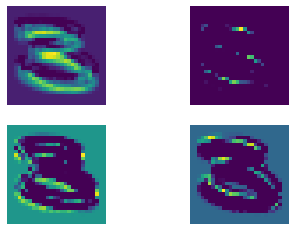


Conv_layer 2 maps training: 


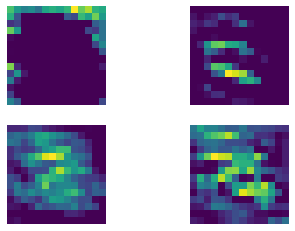


Conv layer 1 maps testing: 


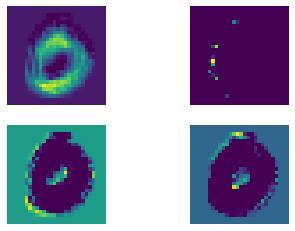


Conv_layer 2 maps testing: 


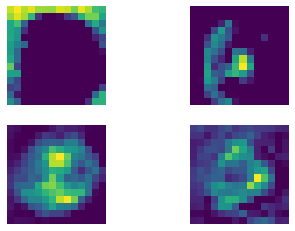

Epoch [1], train_loss: 0.3257,train_acc: 0.0940,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


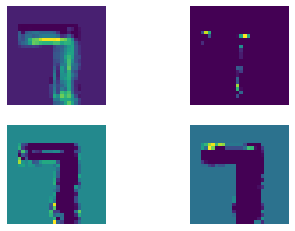


Conv_layer 2 maps training: 


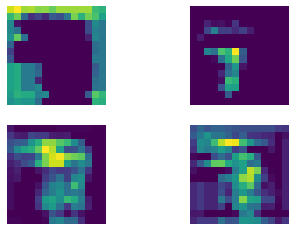


Conv layer 1 maps testing: 


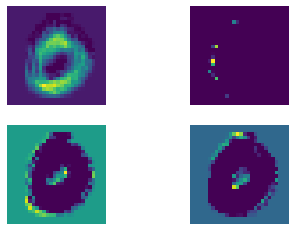


Conv_layer 2 maps testing: 


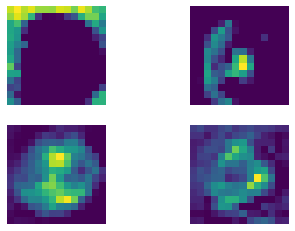

Epoch [2], train_loss: 0.3257,train_acc: 0.0930,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


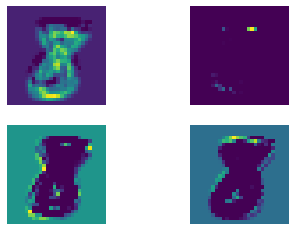


Conv_layer 2 maps training: 


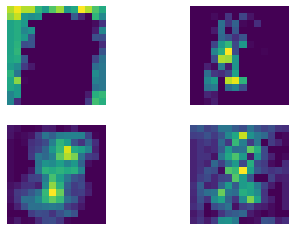


Conv layer 1 maps testing: 


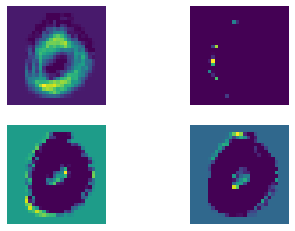


Conv_layer 2 maps testing: 


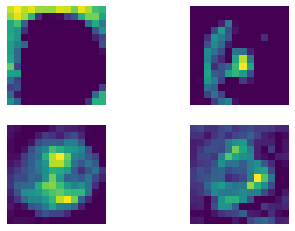

Epoch [3], train_loss: 0.3257,train_acc: 0.0930,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


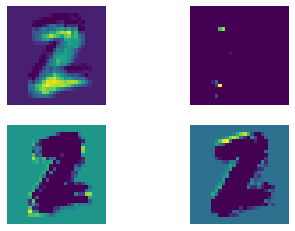


Conv_layer 2 maps training: 


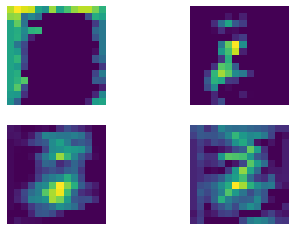


Conv layer 1 maps testing: 


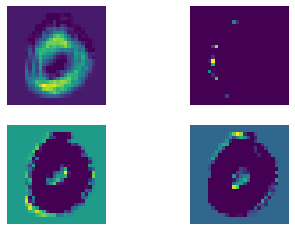


Conv_layer 2 maps testing: 


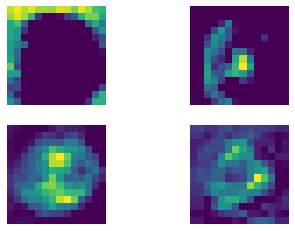

Epoch [4], train_loss: 0.3257,train_acc: 0.0930,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


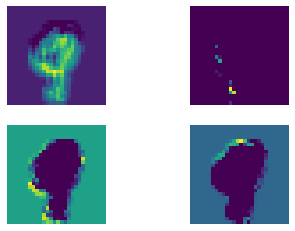


Conv_layer 2 maps training: 


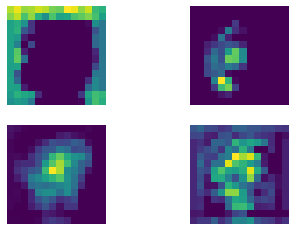


Conv layer 1 maps testing: 


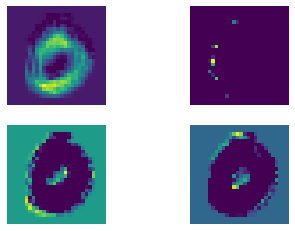


Conv_layer 2 maps testing: 


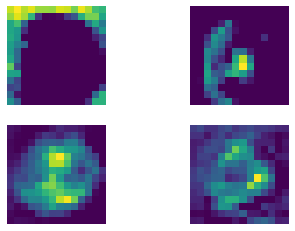

Epoch [5], train_loss: 0.3257,train_acc: 0.0930,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


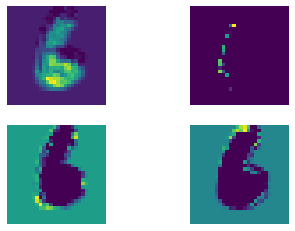


Conv_layer 2 maps training: 


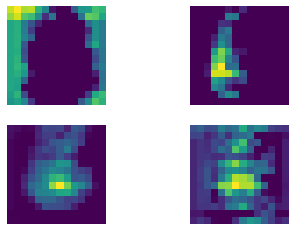


Conv layer 1 maps testing: 


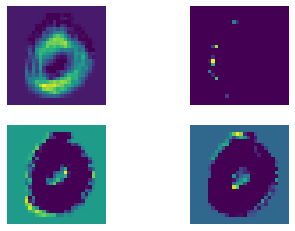


Conv_layer 2 maps testing: 


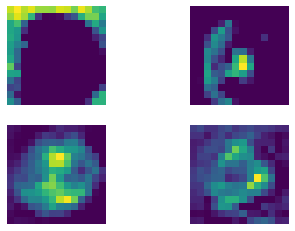

Epoch [6], train_loss: 0.3257,train_acc: 0.0930,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


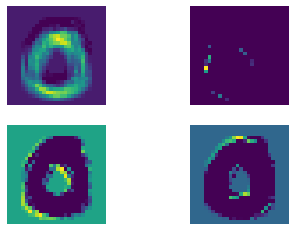


Conv_layer 2 maps training: 


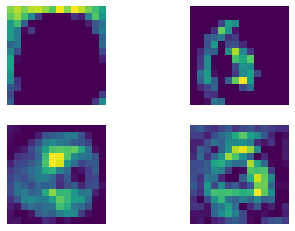


Conv layer 1 maps testing: 


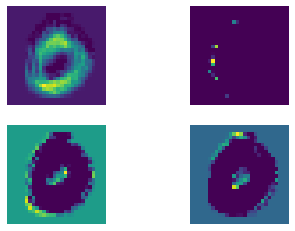


Conv_layer 2 maps testing: 


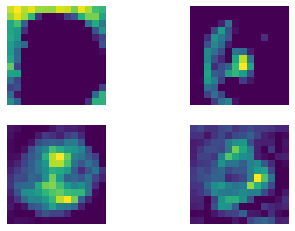

Epoch [7], train_loss: 0.3257,train_acc: 0.0930,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


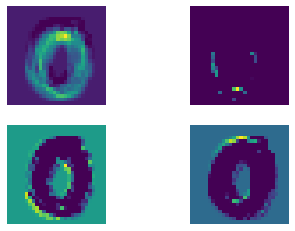


Conv_layer 2 maps training: 


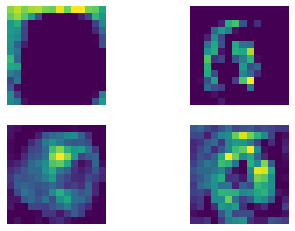


Conv layer 1 maps testing: 


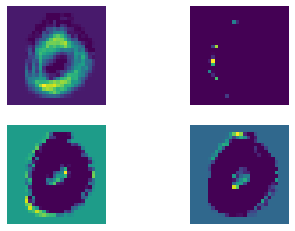


Conv_layer 2 maps testing: 


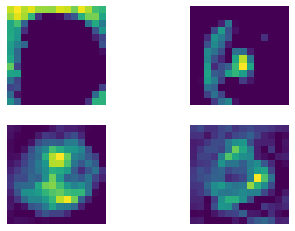

Epoch [8], train_loss: 0.3257,train_acc: 0.0930,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


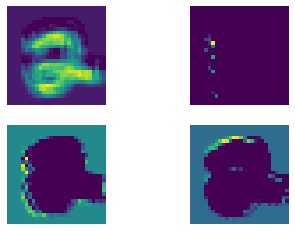


Conv_layer 2 maps training: 


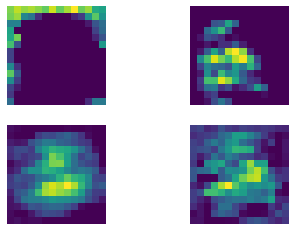


Conv layer 1 maps testing: 


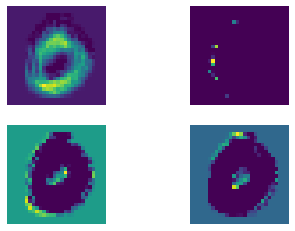


Conv_layer 2 maps testing: 


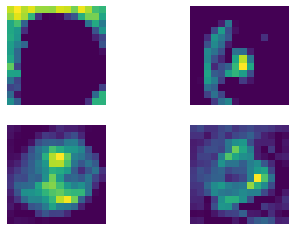

Epoch [9], train_loss: 0.3257,train_acc: 0.0920,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


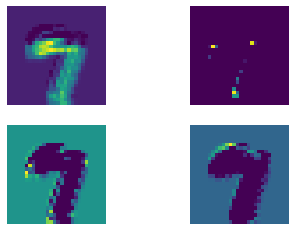


Conv_layer 2 maps training: 


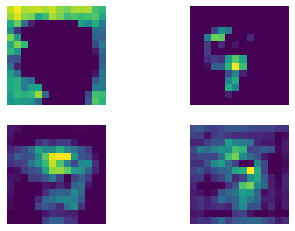


Conv layer 1 maps testing: 


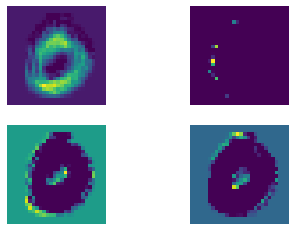


Conv_layer 2 maps testing: 


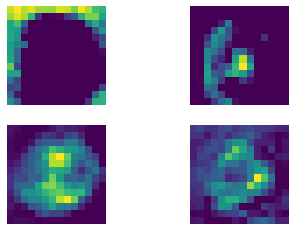

Epoch [10], train_loss: 0.3257,train_acc: 0.0920,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


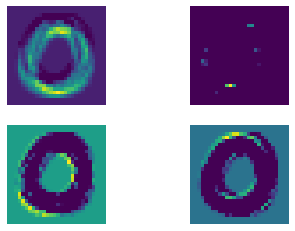


Conv_layer 2 maps training: 


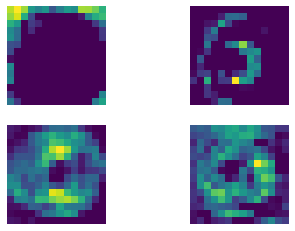


Conv layer 1 maps testing: 


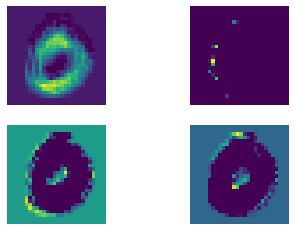


Conv_layer 2 maps testing: 


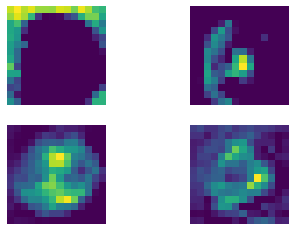

Epoch [11], train_loss: 0.3257,train_acc: 0.0920,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


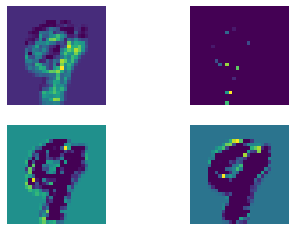


Conv_layer 2 maps training: 


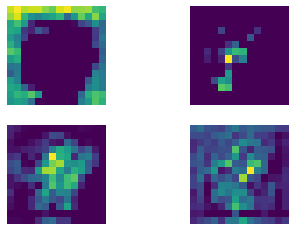


Conv layer 1 maps testing: 


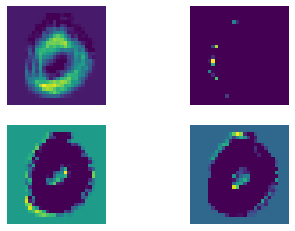


Conv_layer 2 maps testing: 


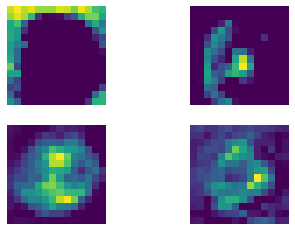

Epoch [12], train_loss: 0.3257,train_acc: 0.0920,test_loss: 0.3257,test_acc: 0.0800

Conv layer 1 maps training: 


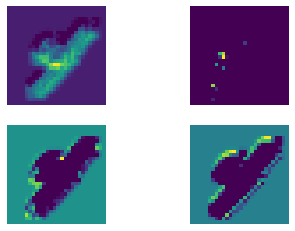


Conv_layer 2 maps training: 


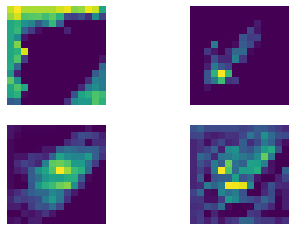


Conv layer 1 maps testing: 


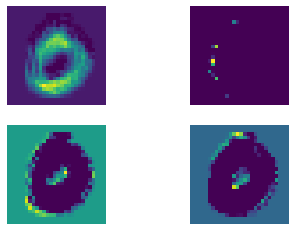


Conv_layer 2 maps testing: 


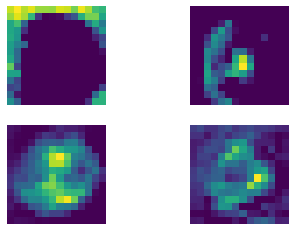

Epoch [13], train_loss: 0.3257,train_acc: 0.0920,test_loss: 0.3256,test_acc: 0.0800

Conv layer 1 maps training: 


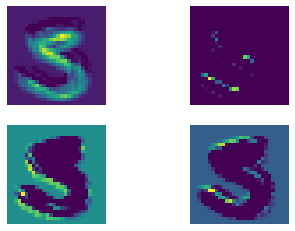


Conv_layer 2 maps training: 


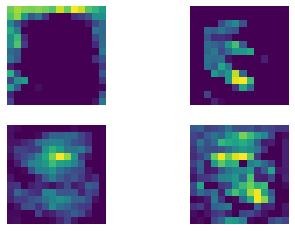


Conv layer 1 maps testing: 


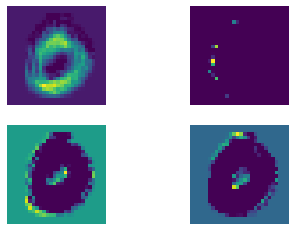


Conv_layer 2 maps testing: 


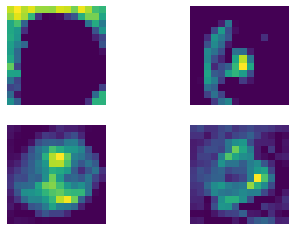

Epoch [14], train_loss: 0.3256,train_acc: 0.0920,test_loss: 0.3256,test_acc: 0.0800

Conv layer 1 maps training: 


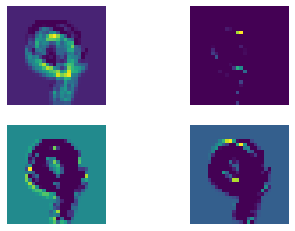


Conv_layer 2 maps training: 


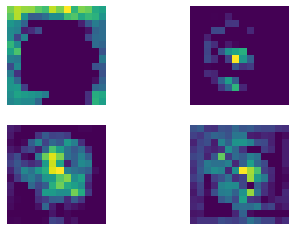


Conv layer 1 maps testing: 


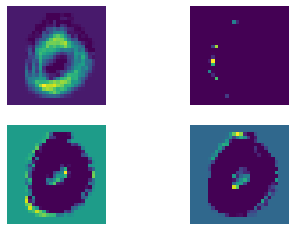


Conv_layer 2 maps testing: 


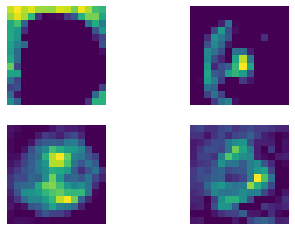

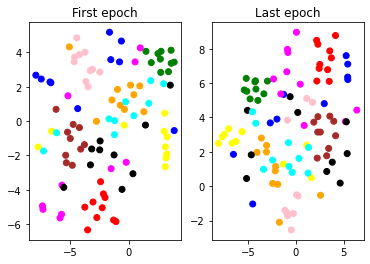

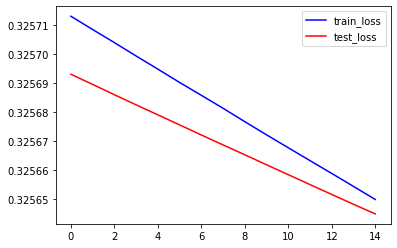

In [228]:
# SGD
model1 = CNN()
optimizer1 = optim.SGD(model1.parameters(),lr=0.001,momentum=0)
history1 = fit(epochs=15,model=model1,train_loader=train_loader1,test_loader=test_loader,optimizer=optimizer1)
plot_loss(history1)

C:\Users\aksha\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0], train_loss: 0.3258,train_acc: 0.1280,test_loss: 0.3257,test_acc: 0.1100

Conv layer 1 maps training: 


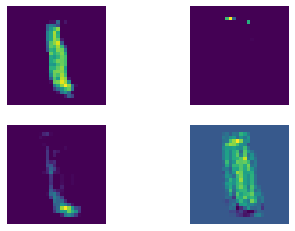


Conv_layer 2 maps training: 


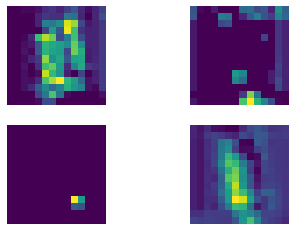


Conv layer 1 maps testing: 


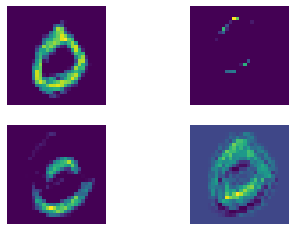


Conv_layer 2 maps testing: 


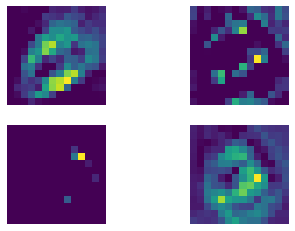

Epoch [1], train_loss: 0.3257,train_acc: 0.1290,test_loss: 0.3256,test_acc: 0.1100

Conv layer 1 maps training: 


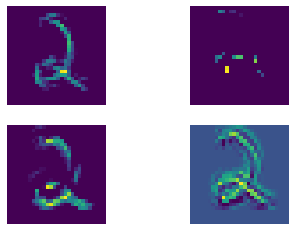


Conv_layer 2 maps training: 


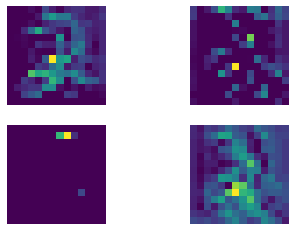


Conv layer 1 maps testing: 


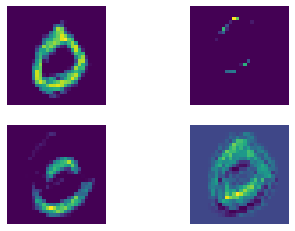


Conv_layer 2 maps testing: 


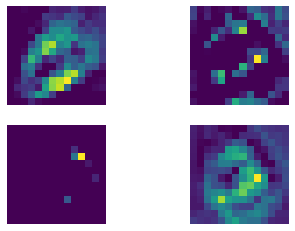

Epoch [2], train_loss: 0.3257,train_acc: 0.1280,test_loss: 0.3256,test_acc: 0.1100

Conv layer 1 maps training: 


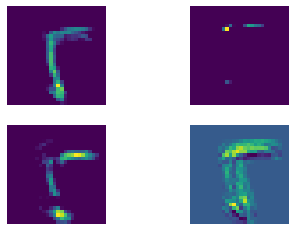


Conv_layer 2 maps training: 


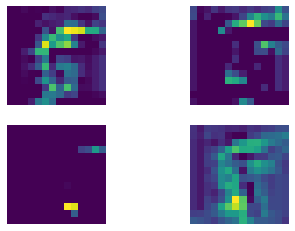


Conv layer 1 maps testing: 


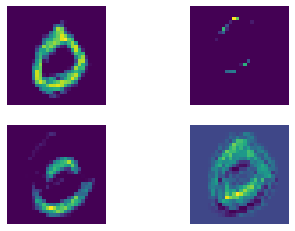


Conv_layer 2 maps testing: 


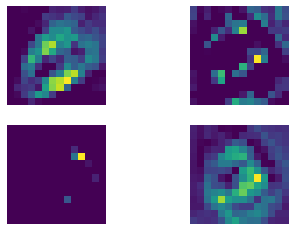

Epoch [3], train_loss: 0.3256,train_acc: 0.1260,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


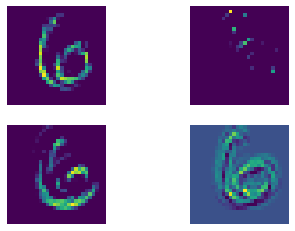


Conv_layer 2 maps training: 


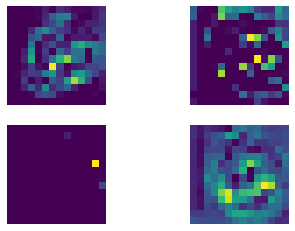


Conv layer 1 maps testing: 


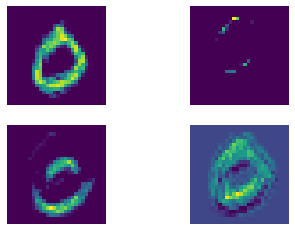


Conv_layer 2 maps testing: 


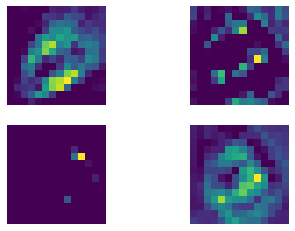

Epoch [4], train_loss: 0.3255,train_acc: 0.1240,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


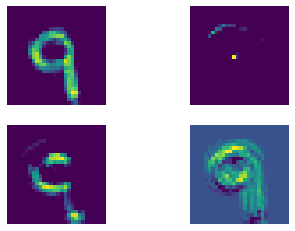


Conv_layer 2 maps training: 


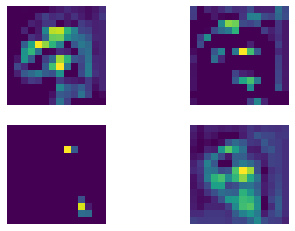


Conv layer 1 maps testing: 


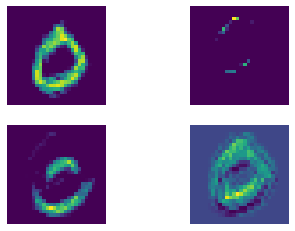


Conv_layer 2 maps testing: 


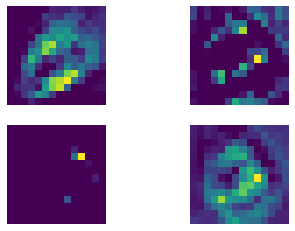

Epoch [5], train_loss: 0.3255,train_acc: 0.1240,test_loss: 0.3254,test_acc: 0.1000

Conv layer 1 maps training: 


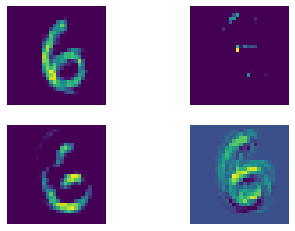


Conv_layer 2 maps training: 


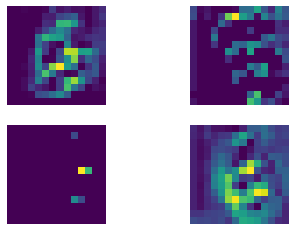


Conv layer 1 maps testing: 


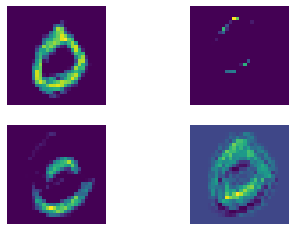


Conv_layer 2 maps testing: 


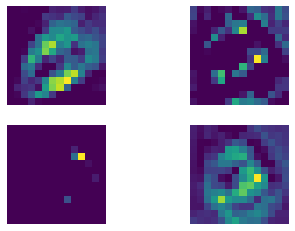

Epoch [6], train_loss: 0.3254,train_acc: 0.1240,test_loss: 0.3254,test_acc: 0.1000

Conv layer 1 maps training: 


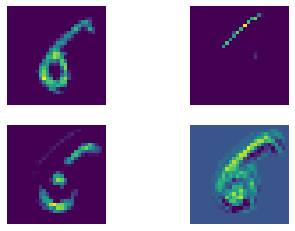


Conv_layer 2 maps training: 


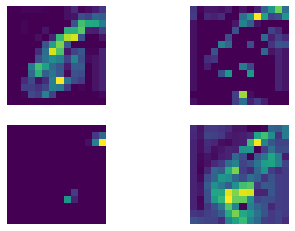


Conv layer 1 maps testing: 


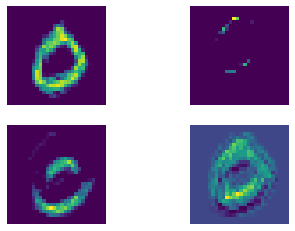


Conv_layer 2 maps testing: 


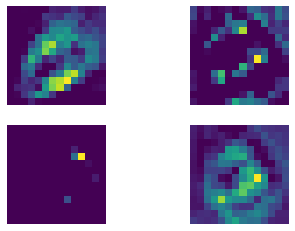

Epoch [7], train_loss: 0.3254,train_acc: 0.1220,test_loss: 0.3253,test_acc: 0.1000

Conv layer 1 maps training: 


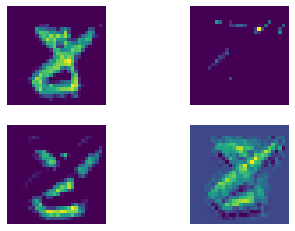


Conv_layer 2 maps training: 


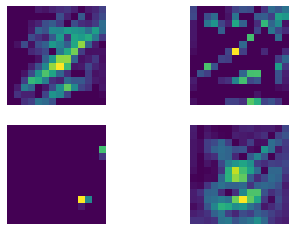


Conv layer 1 maps testing: 


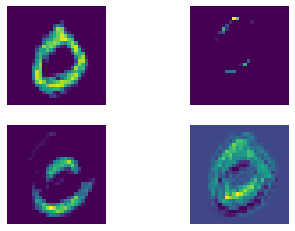


Conv_layer 2 maps testing: 


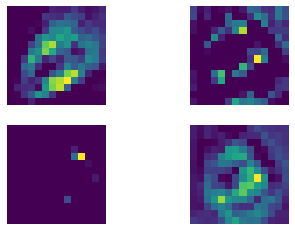

Epoch [8], train_loss: 0.3253,train_acc: 0.1230,test_loss: 0.3253,test_acc: 0.1000

Conv layer 1 maps training: 


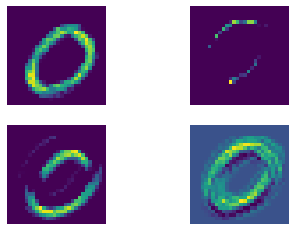


Conv_layer 2 maps training: 


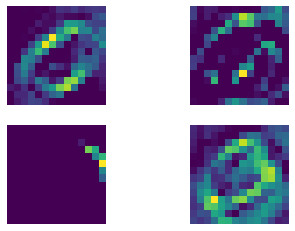


Conv layer 1 maps testing: 


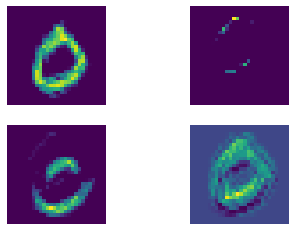


Conv_layer 2 maps testing: 


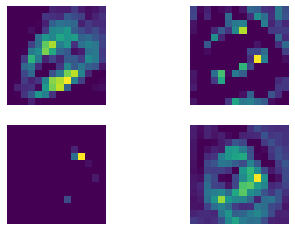

Epoch [9], train_loss: 0.3253,train_acc: 0.1220,test_loss: 0.3253,test_acc: 0.1000

Conv layer 1 maps training: 


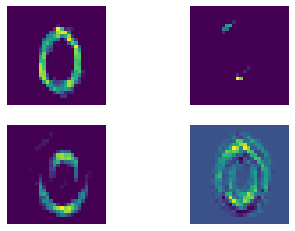


Conv_layer 2 maps training: 


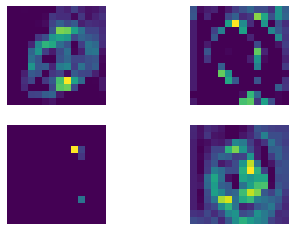


Conv layer 1 maps testing: 


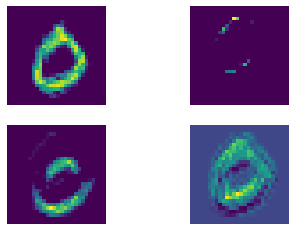


Conv_layer 2 maps testing: 


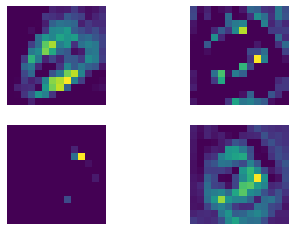

Epoch [10], train_loss: 0.3252,train_acc: 0.1210,test_loss: 0.3252,test_acc: 0.1000

Conv layer 1 maps training: 


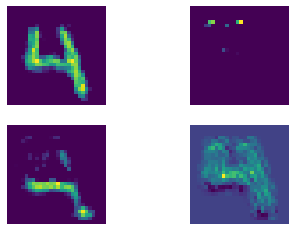


Conv_layer 2 maps training: 


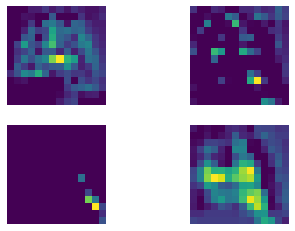


Conv layer 1 maps testing: 


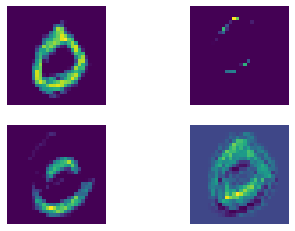


Conv_layer 2 maps testing: 


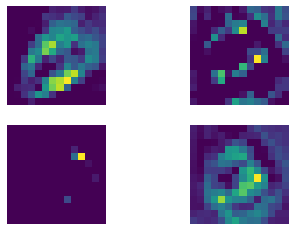

Epoch [11], train_loss: 0.3252,train_acc: 0.1210,test_loss: 0.3252,test_acc: 0.1000

Conv layer 1 maps training: 


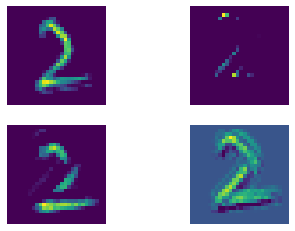


Conv_layer 2 maps training: 


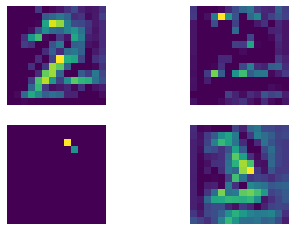


Conv layer 1 maps testing: 


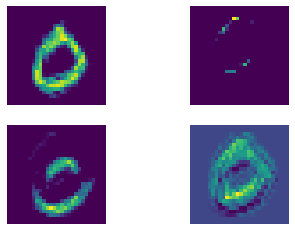


Conv_layer 2 maps testing: 


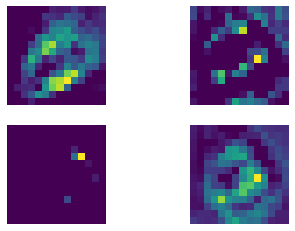

Epoch [12], train_loss: 0.3251,train_acc: 0.1210,test_loss: 0.3251,test_acc: 0.1000

Conv layer 1 maps training: 


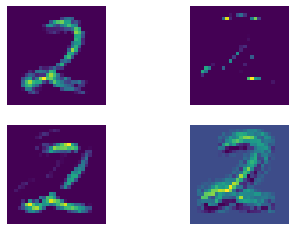


Conv_layer 2 maps training: 


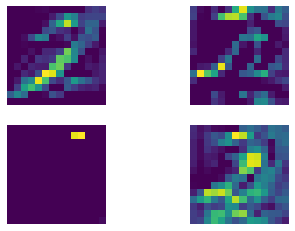


Conv layer 1 maps testing: 


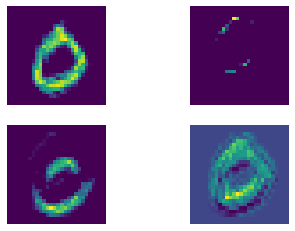


Conv_layer 2 maps testing: 


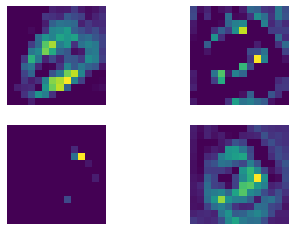

Epoch [13], train_loss: 0.3251,train_acc: 0.1210,test_loss: 0.3251,test_acc: 0.1000

Conv layer 1 maps training: 


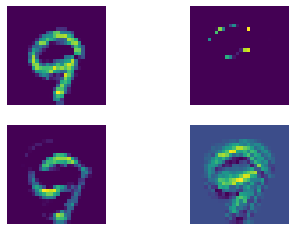


Conv_layer 2 maps training: 


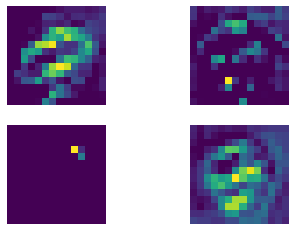


Conv layer 1 maps testing: 


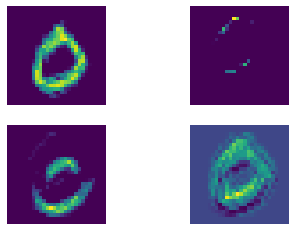


Conv_layer 2 maps testing: 


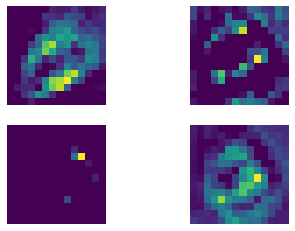

Epoch [14], train_loss: 0.3250,train_acc: 0.1210,test_loss: 0.3251,test_acc: 0.1000

Conv layer 1 maps training: 


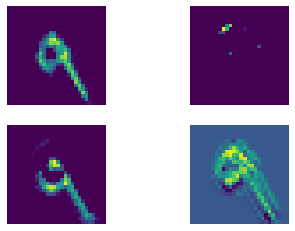


Conv_layer 2 maps training: 


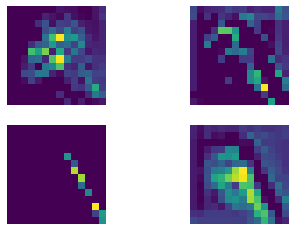


Conv layer 1 maps testing: 


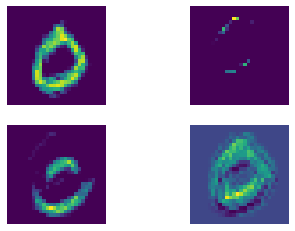


Conv_layer 2 maps testing: 


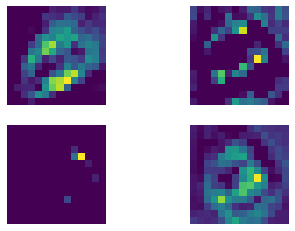

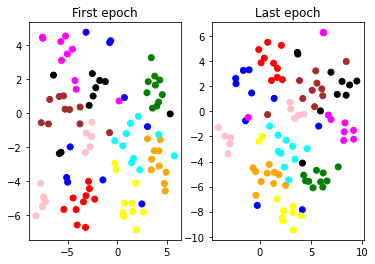

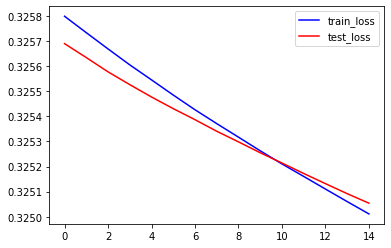

In [229]:
#Momentum
model2 = CNN()
optimizer2 = optim.SGD(model2.parameters(),lr=0.001,momentum=0.9)
history2 = fit(epochs=15,model=model2,train_loader=train_loader1,test_loader=test_loader,optimizer=optimizer2)
plot_loss(history2)

C:\Users\aksha\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0], train_loss: 0.3029,train_acc: 0.3310,test_loss: 0.2414,test_acc: 0.6400

Conv layer 1 maps training: 


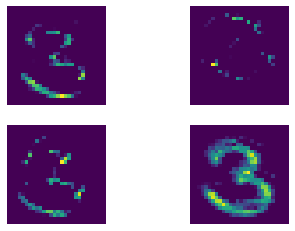


Conv_layer 2 maps training: 


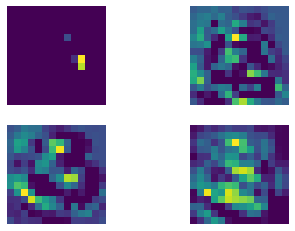


Conv layer 1 maps testing: 


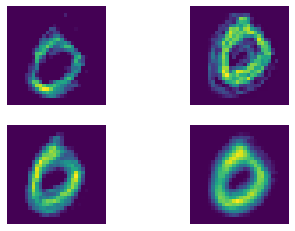


Conv_layer 2 maps testing: 


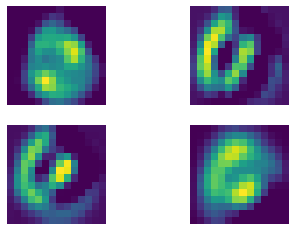

Epoch [1], train_loss: 0.1788,train_acc: 0.6690,test_loss: 0.1264,test_acc: 0.7100

Conv layer 1 maps training: 


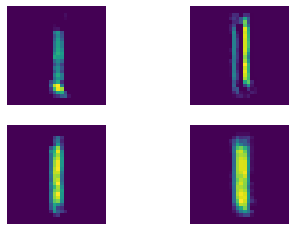


Conv_layer 2 maps training: 


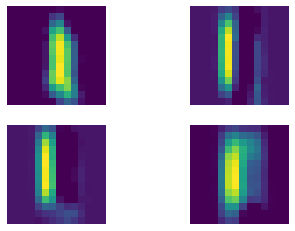


Conv layer 1 maps testing: 


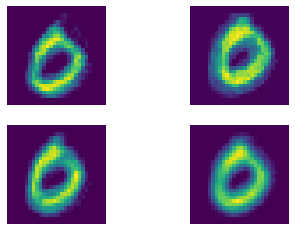


Conv_layer 2 maps testing: 


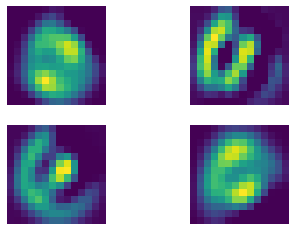

Epoch [2], train_loss: 0.1133,train_acc: 0.7830,test_loss: 0.1042,test_acc: 0.7100

Conv layer 1 maps training: 


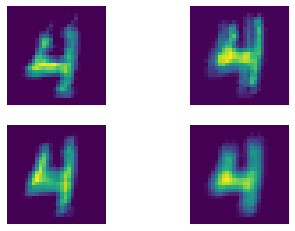


Conv_layer 2 maps training: 


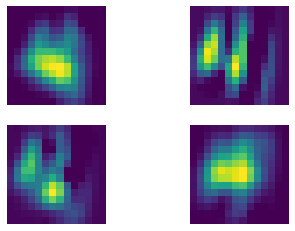


Conv layer 1 maps testing: 


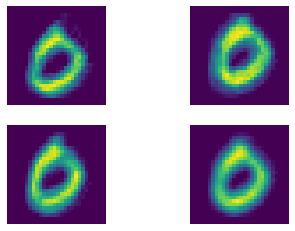


Conv_layer 2 maps testing: 


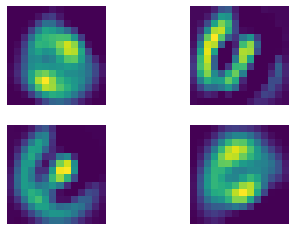

Epoch [3], train_loss: 0.0912,train_acc: 0.8250,test_loss: 0.0736,test_acc: 0.8600

Conv layer 1 maps training: 


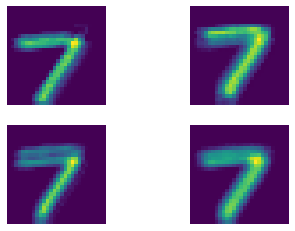


Conv_layer 2 maps training: 


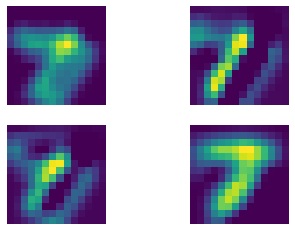


Conv layer 1 maps testing: 


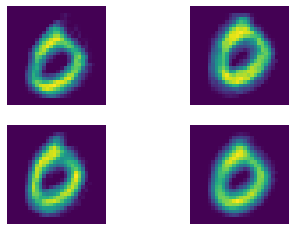


Conv_layer 2 maps testing: 


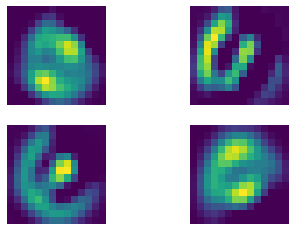

Epoch [4], train_loss: 0.0789,train_acc: 0.8480,test_loss: 0.0737,test_acc: 0.8200

Conv layer 1 maps training: 


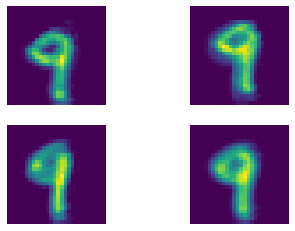


Conv_layer 2 maps training: 


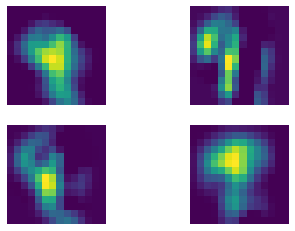


Conv layer 1 maps testing: 


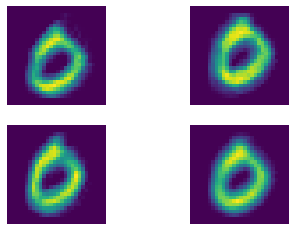


Conv_layer 2 maps testing: 


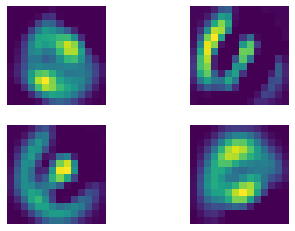

Epoch [5], train_loss: 0.0699,train_acc: 0.8660,test_loss: 0.0460,test_acc: 0.9000

Conv layer 1 maps training: 


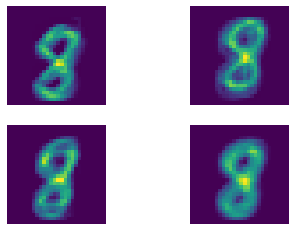


Conv_layer 2 maps training: 


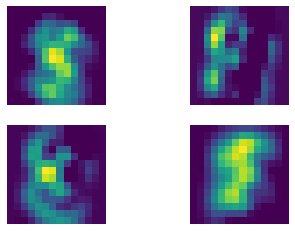


Conv layer 1 maps testing: 


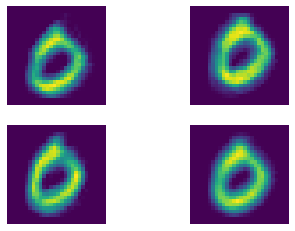


Conv_layer 2 maps testing: 


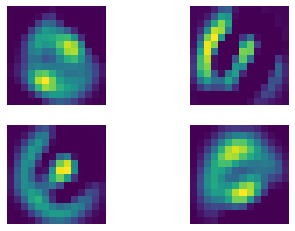

Epoch [6], train_loss: 0.0653,train_acc: 0.8700,test_loss: 0.0469,test_acc: 0.9300

Conv layer 1 maps training: 


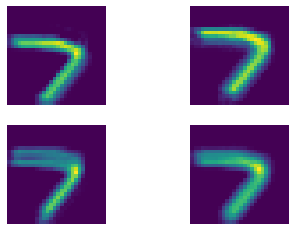


Conv_layer 2 maps training: 


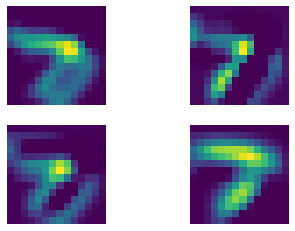


Conv layer 1 maps testing: 


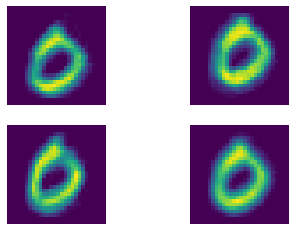


Conv_layer 2 maps testing: 


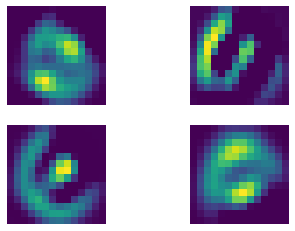

Epoch [7], train_loss: 0.0568,train_acc: 0.8920,test_loss: 0.0423,test_acc: 0.9400

Conv layer 1 maps training: 


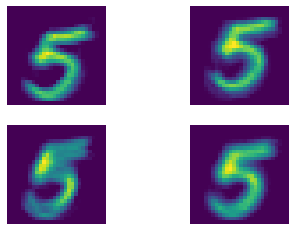


Conv_layer 2 maps training: 


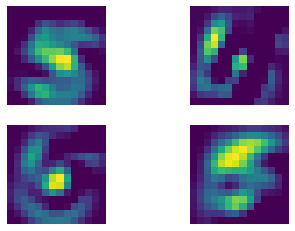


Conv layer 1 maps testing: 


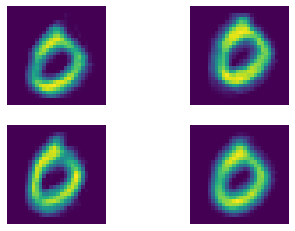


Conv_layer 2 maps testing: 


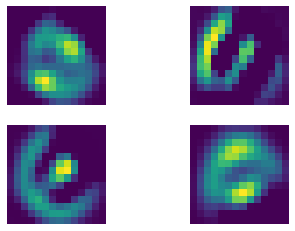

Epoch [8], train_loss: 0.0529,train_acc: 0.9000,test_loss: 0.0314,test_acc: 0.9600

Conv layer 1 maps training: 


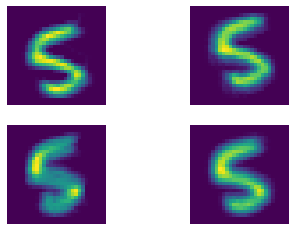


Conv_layer 2 maps training: 


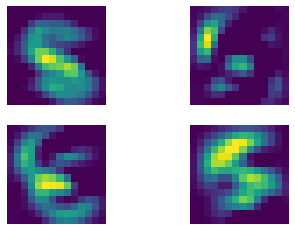


Conv layer 1 maps testing: 


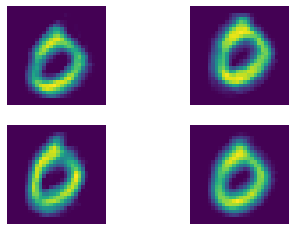


Conv_layer 2 maps testing: 


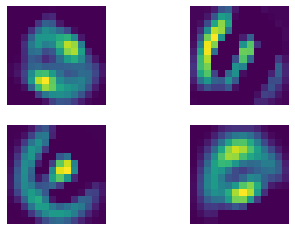

Epoch [9], train_loss: 0.0484,train_acc: 0.9110,test_loss: 0.0261,test_acc: 0.9500

Conv layer 1 maps training: 


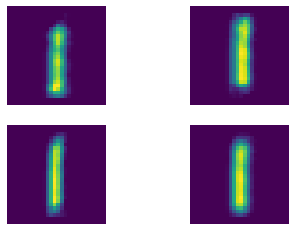


Conv_layer 2 maps training: 


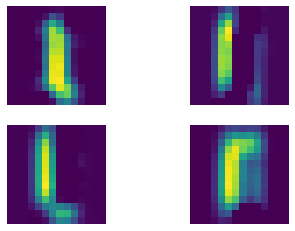


Conv layer 1 maps testing: 


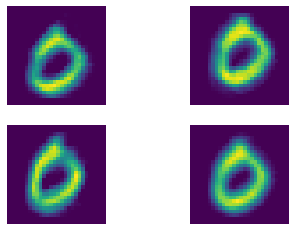


Conv_layer 2 maps testing: 


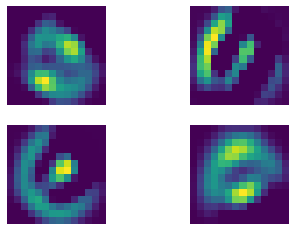

Epoch [10], train_loss: 0.0432,train_acc: 0.9190,test_loss: 0.0236,test_acc: 0.9500

Conv layer 1 maps training: 


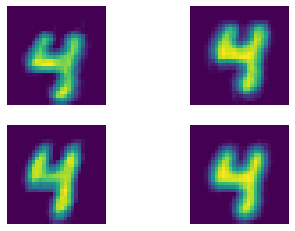


Conv_layer 2 maps training: 


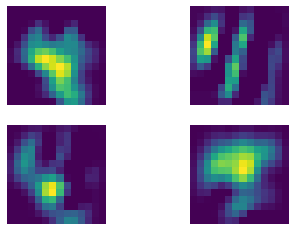


Conv layer 1 maps testing: 


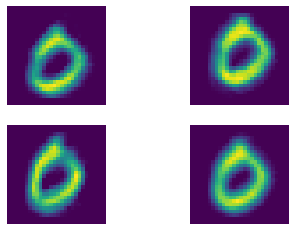


Conv_layer 2 maps testing: 


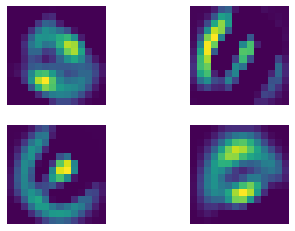

Epoch [11], train_loss: 0.0422,train_acc: 0.9170,test_loss: 0.0217,test_acc: 0.9600

Conv layer 1 maps training: 


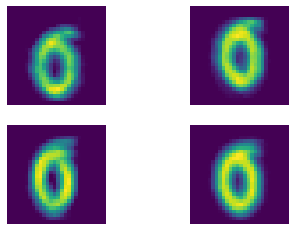


Conv_layer 2 maps training: 


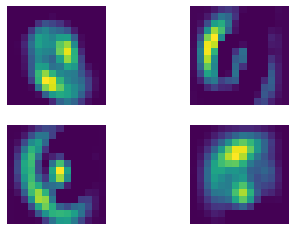


Conv layer 1 maps testing: 


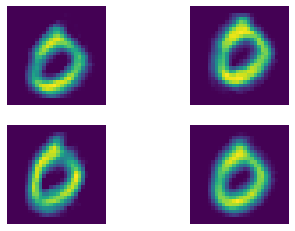


Conv_layer 2 maps testing: 


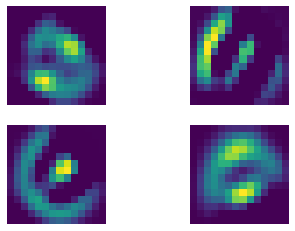

Epoch [12], train_loss: 0.0384,train_acc: 0.9270,test_loss: 0.0179,test_acc: 0.9800

Conv layer 1 maps training: 


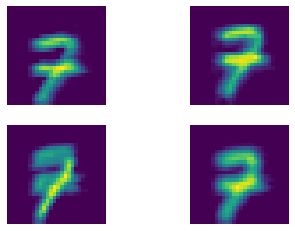


Conv_layer 2 maps training: 


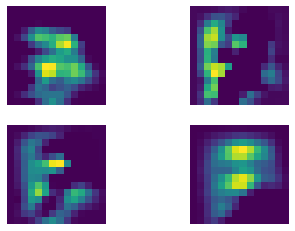


Conv layer 1 maps testing: 


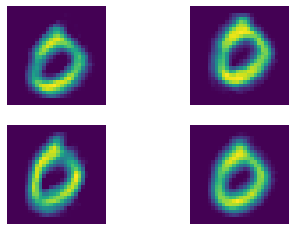


Conv_layer 2 maps testing: 


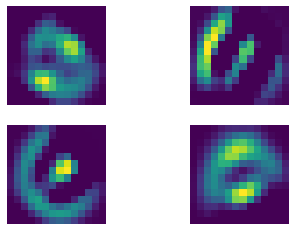

Epoch [13], train_loss: 0.0360,train_acc: 0.9370,test_loss: 0.0178,test_acc: 0.9700

Conv layer 1 maps training: 


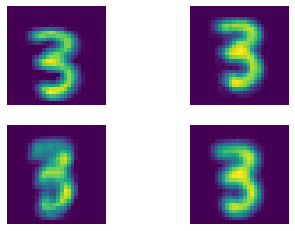


Conv_layer 2 maps training: 


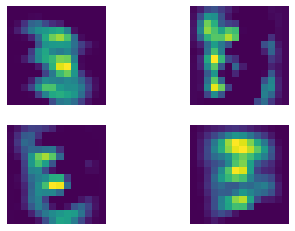


Conv layer 1 maps testing: 


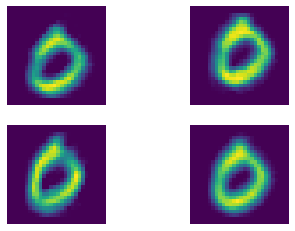


Conv_layer 2 maps testing: 


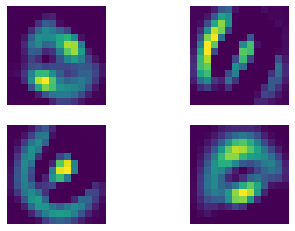

Epoch [14], train_loss: 0.0303,train_acc: 0.9450,test_loss: 0.0186,test_acc: 0.9600

Conv layer 1 maps training: 


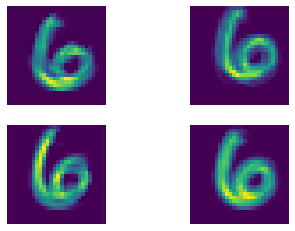


Conv_layer 2 maps training: 


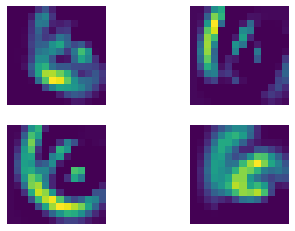


Conv layer 1 maps testing: 


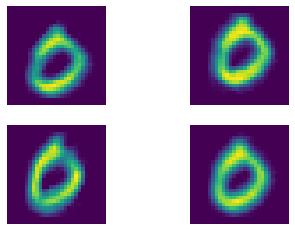


Conv_layer 2 maps testing: 


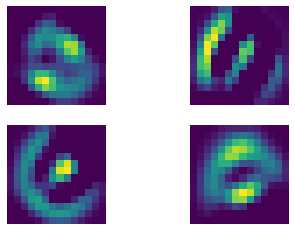

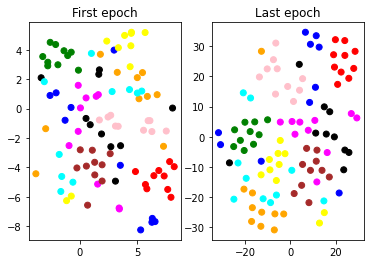

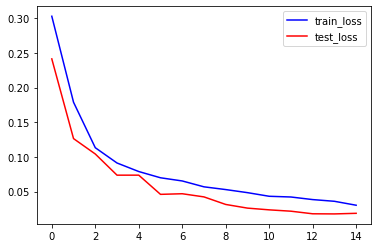

In [230]:
#RMSProp
model3 = CNN()
optimizer3 = optim.RMSprop(model3.parameters(),alpha = 0.9,lr=0.001)
history3 = fit(epochs=15,model=model3,train_loader=train_loader1,test_loader=test_loader,optimizer=optimizer3)
plot_loss(history3)

## Vanilla batch size 50

C:\Users\aksha\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0], train_loss: 0.3259,train_acc: 0.0940,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


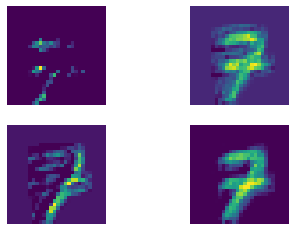


Conv_layer 2 maps training: 


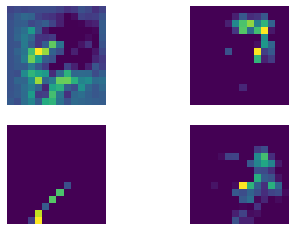


Conv layer 1 maps testing: 


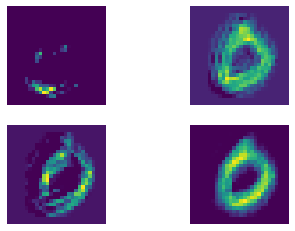


Conv_layer 2 maps testing: 


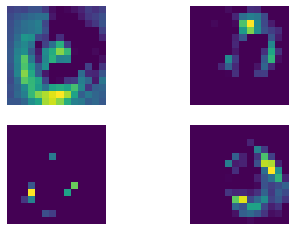

Epoch [1], train_loss: 0.3259,train_acc: 0.0940,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


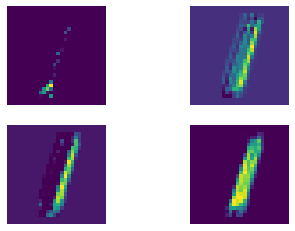


Conv_layer 2 maps training: 


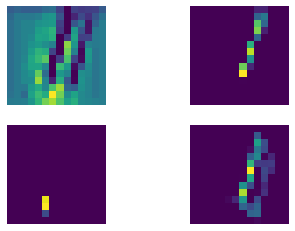


Conv layer 1 maps testing: 


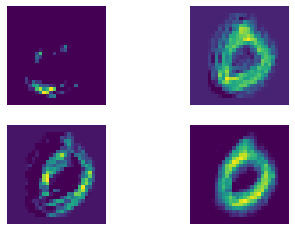


Conv_layer 2 maps testing: 


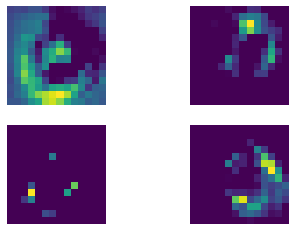

Epoch [2], train_loss: 0.3259,train_acc: 0.0940,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


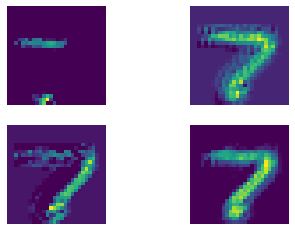


Conv_layer 2 maps training: 


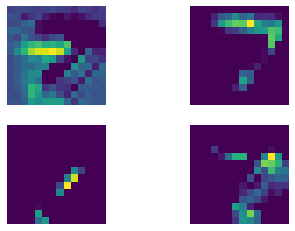


Conv layer 1 maps testing: 


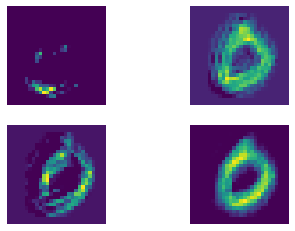


Conv_layer 2 maps testing: 


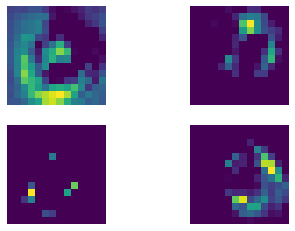

Epoch [3], train_loss: 0.3259,train_acc: 0.0940,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


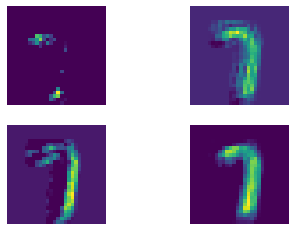


Conv_layer 2 maps training: 


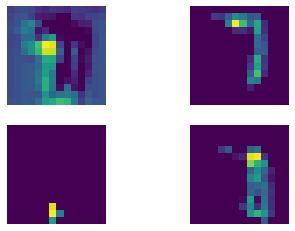


Conv layer 1 maps testing: 


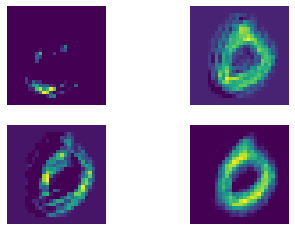


Conv_layer 2 maps testing: 


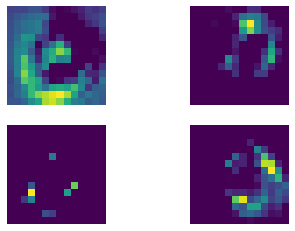

Epoch [4], train_loss: 0.3259,train_acc: 0.0940,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


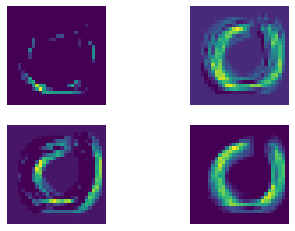


Conv_layer 2 maps training: 


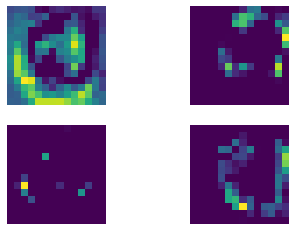


Conv layer 1 maps testing: 


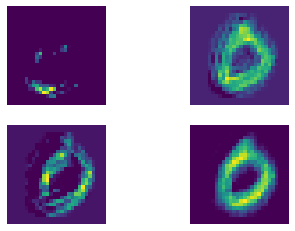


Conv_layer 2 maps testing: 


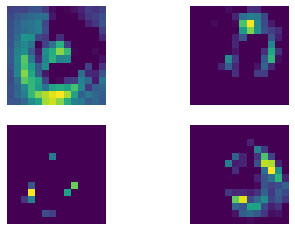

Epoch [5], train_loss: 0.3259,train_acc: 0.0940,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


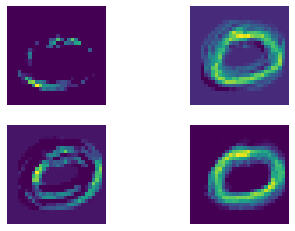


Conv_layer 2 maps training: 


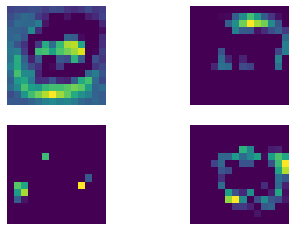


Conv layer 1 maps testing: 


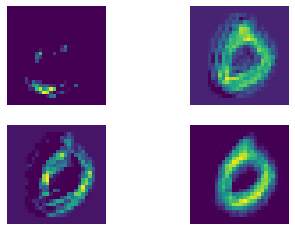


Conv_layer 2 maps testing: 


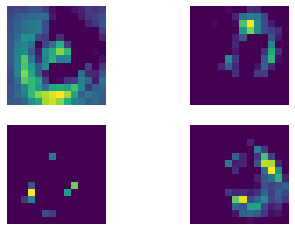

Epoch [6], train_loss: 0.3259,train_acc: 0.0940,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


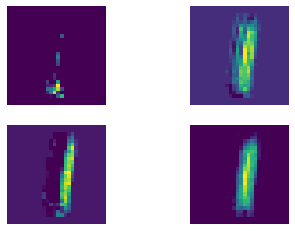


Conv_layer 2 maps training: 


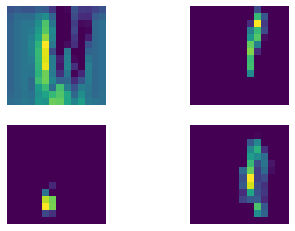


Conv layer 1 maps testing: 


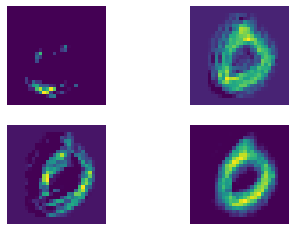


Conv_layer 2 maps testing: 


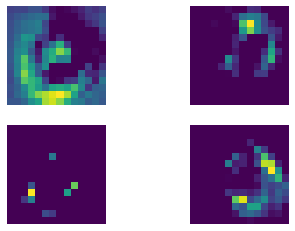

Epoch [7], train_loss: 0.3259,train_acc: 0.0940,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


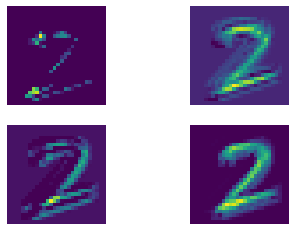


Conv_layer 2 maps training: 


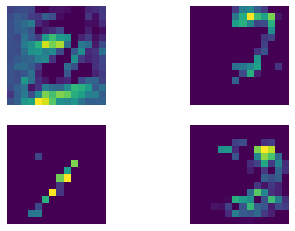


Conv layer 1 maps testing: 


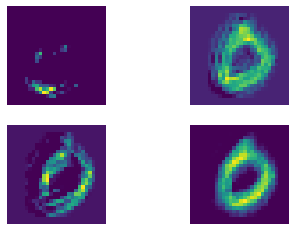


Conv_layer 2 maps testing: 


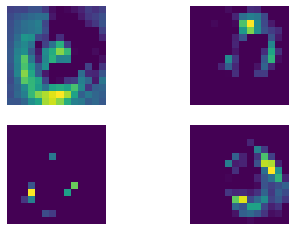

Epoch [8], train_loss: 0.3258,train_acc: 0.0940,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


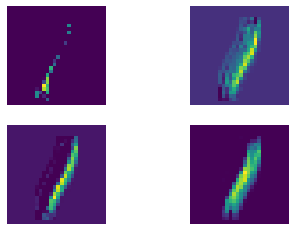


Conv_layer 2 maps training: 


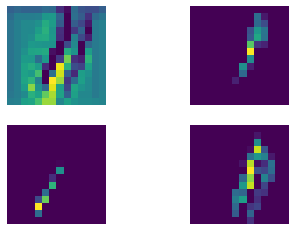


Conv layer 1 maps testing: 


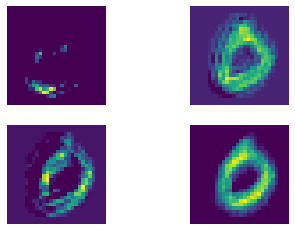


Conv_layer 2 maps testing: 


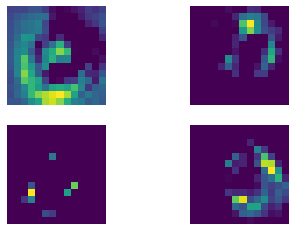

Epoch [9], train_loss: 0.3258,train_acc: 0.0940,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


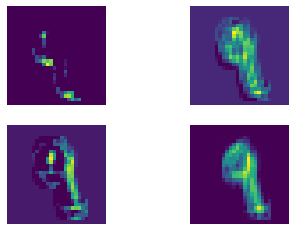


Conv_layer 2 maps training: 


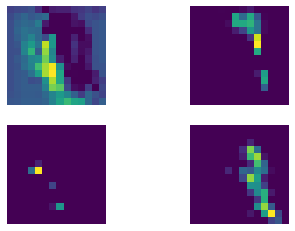


Conv layer 1 maps testing: 


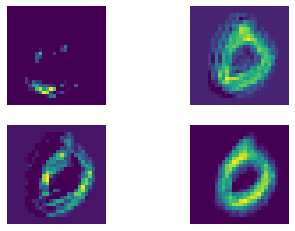


Conv_layer 2 maps testing: 


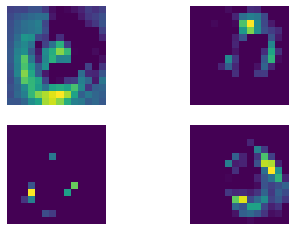

Epoch [10], train_loss: 0.3258,train_acc: 0.0940,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


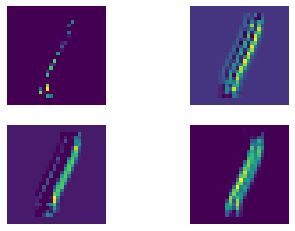


Conv_layer 2 maps training: 


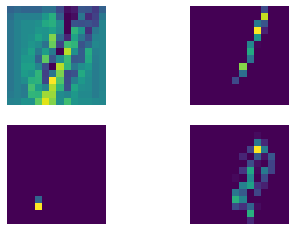


Conv layer 1 maps testing: 


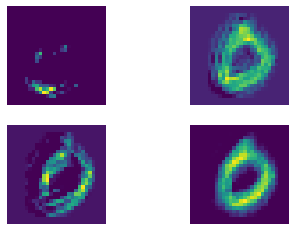


Conv_layer 2 maps testing: 


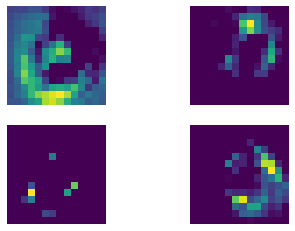

Epoch [11], train_loss: 0.3258,train_acc: 0.0940,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


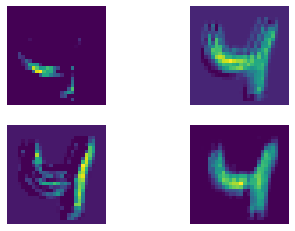


Conv_layer 2 maps training: 


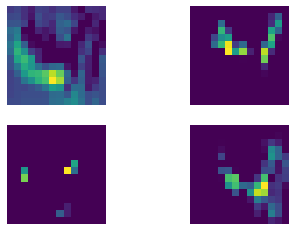


Conv layer 1 maps testing: 


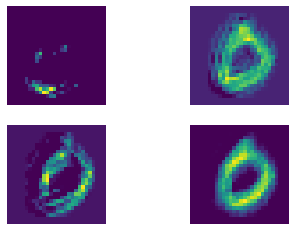


Conv_layer 2 maps testing: 


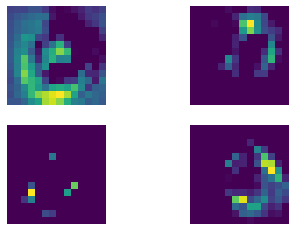

Epoch [12], train_loss: 0.3258,train_acc: 0.0940,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


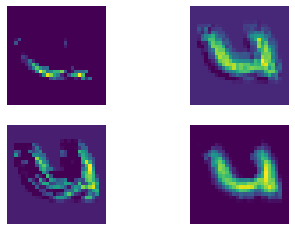


Conv_layer 2 maps training: 


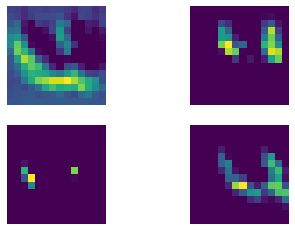


Conv layer 1 maps testing: 


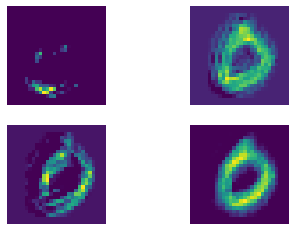


Conv_layer 2 maps testing: 


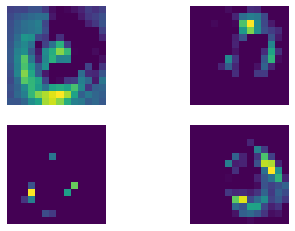

Epoch [13], train_loss: 0.3258,train_acc: 0.0940,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


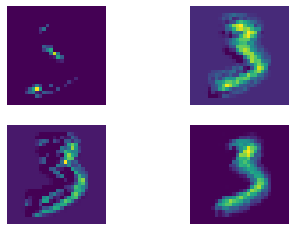


Conv_layer 2 maps training: 


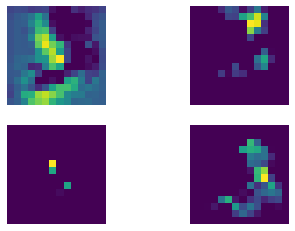


Conv layer 1 maps testing: 


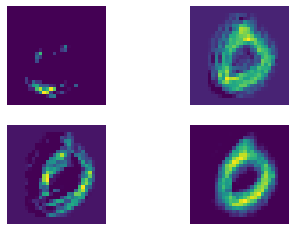


Conv_layer 2 maps testing: 


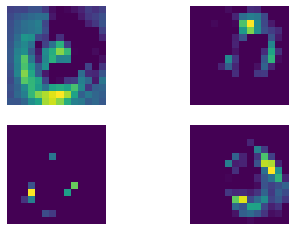

Epoch [14], train_loss: 0.3258,train_acc: 0.0940,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


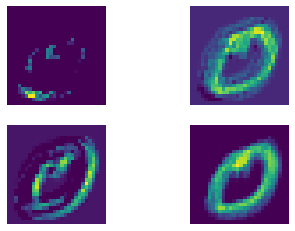


Conv_layer 2 maps training: 


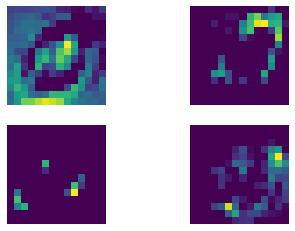


Conv layer 1 maps testing: 


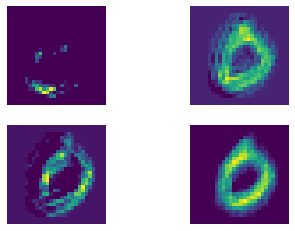


Conv_layer 2 maps testing: 


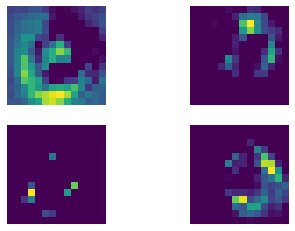

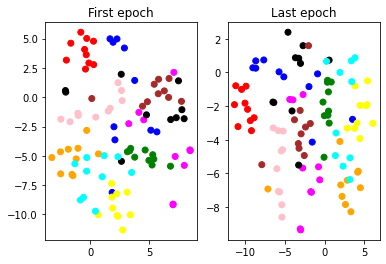

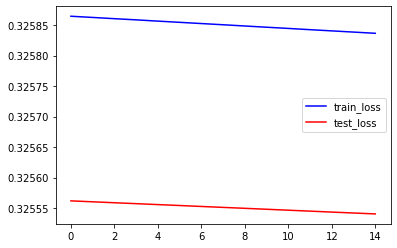

In [244]:
#SGD
model_1 = CNN()
optimizer_1 = optim.SGD(model_1.parameters(),lr=0.001,momentum=0)
history_1 = fit(epochs=15,model=model_1,train_loader=train_loader2,test_loader=test_loader,optimizer=optimizer_1)
plot_loss(history_1)

C:\Users\aksha\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0], train_loss: 0.3251,train_acc: 0.1020,test_loss: 0.3257,test_acc: 0.1000

Conv layer 1 maps training: 


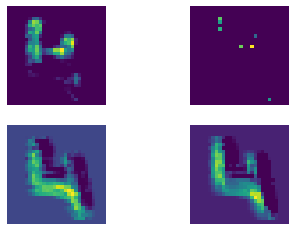


Conv_layer 2 maps training: 


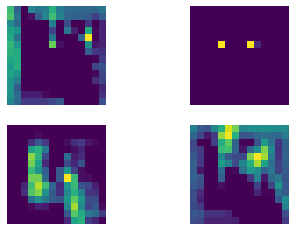


Conv layer 1 maps testing: 


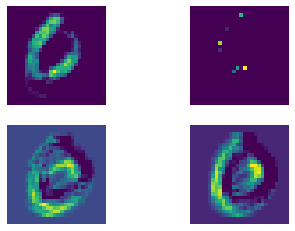


Conv_layer 2 maps testing: 


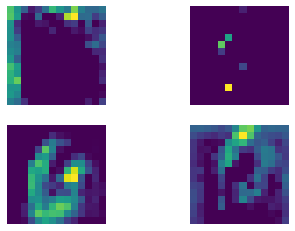

Epoch [1], train_loss: 0.3251,train_acc: 0.1020,test_loss: 0.3257,test_acc: 0.1000

Conv layer 1 maps training: 


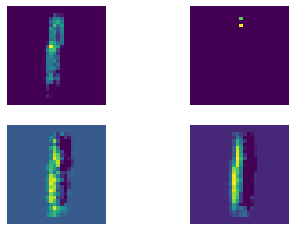


Conv_layer 2 maps training: 


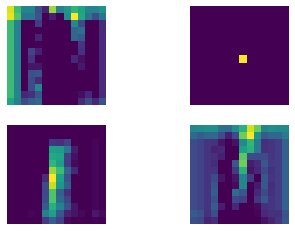


Conv layer 1 maps testing: 


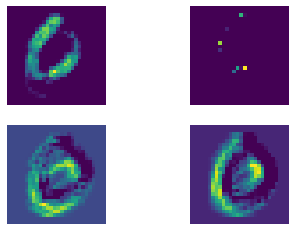


Conv_layer 2 maps testing: 


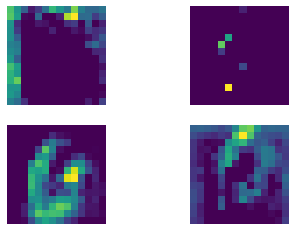

Epoch [2], train_loss: 0.3251,train_acc: 0.1020,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


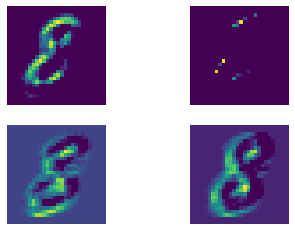


Conv_layer 2 maps training: 


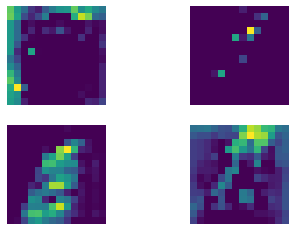


Conv layer 1 maps testing: 


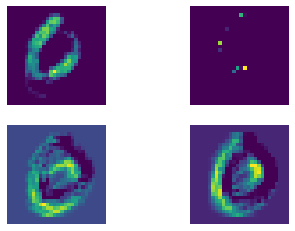


Conv_layer 2 maps testing: 


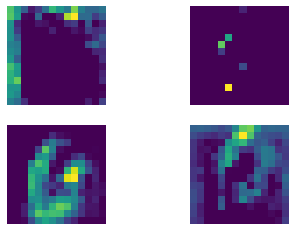

Epoch [3], train_loss: 0.3251,train_acc: 0.1020,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


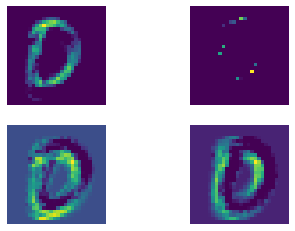


Conv_layer 2 maps training: 


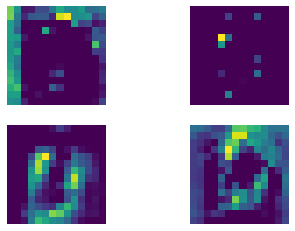


Conv layer 1 maps testing: 


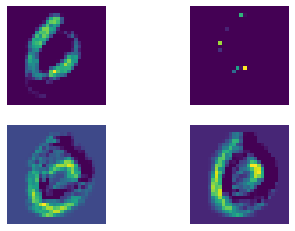


Conv_layer 2 maps testing: 


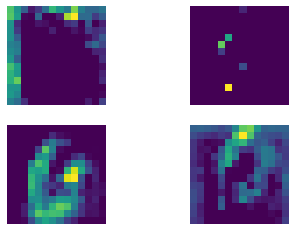

Epoch [4], train_loss: 0.3250,train_acc: 0.1020,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


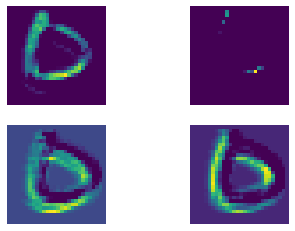


Conv_layer 2 maps training: 


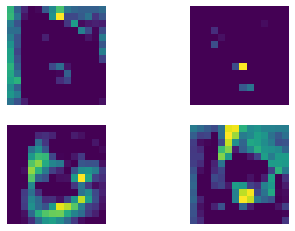


Conv layer 1 maps testing: 


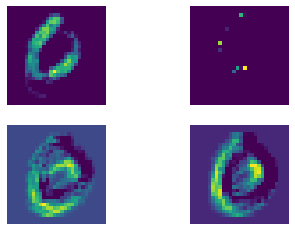


Conv_layer 2 maps testing: 


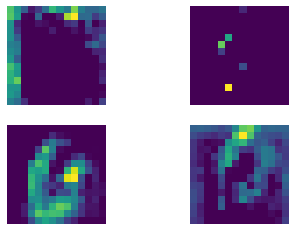

Epoch [5], train_loss: 0.3250,train_acc: 0.1020,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


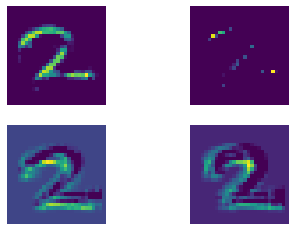


Conv_layer 2 maps training: 


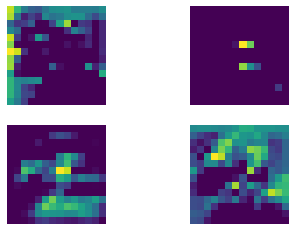


Conv layer 1 maps testing: 


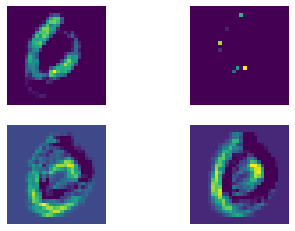


Conv_layer 2 maps testing: 


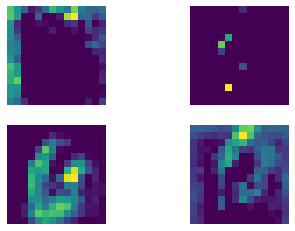

Epoch [6], train_loss: 0.3250,train_acc: 0.1020,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


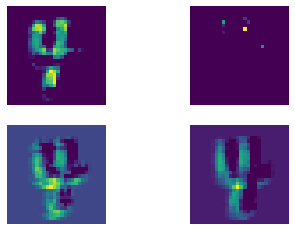


Conv_layer 2 maps training: 


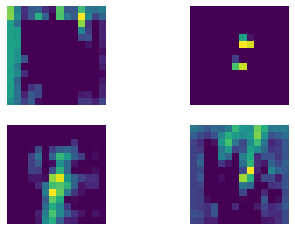


Conv layer 1 maps testing: 


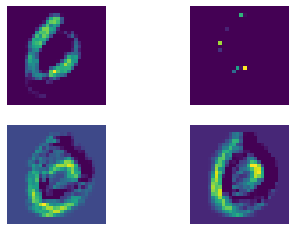


Conv_layer 2 maps testing: 


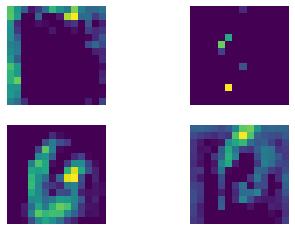

Epoch [7], train_loss: 0.3250,train_acc: 0.1020,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


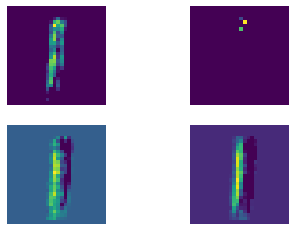


Conv_layer 2 maps training: 


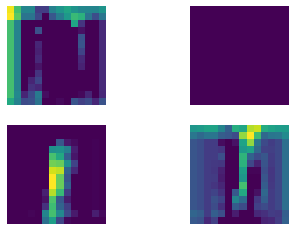


Conv layer 1 maps testing: 


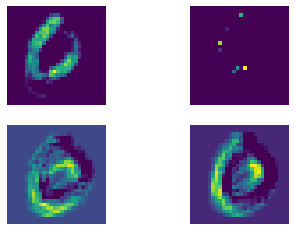


Conv_layer 2 maps testing: 


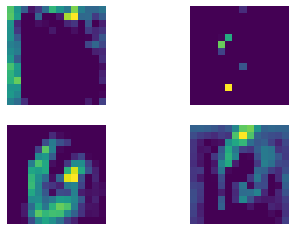

Epoch [8], train_loss: 0.3250,train_acc: 0.1020,test_loss: 0.3256,test_acc: 0.1000

Conv layer 1 maps training: 


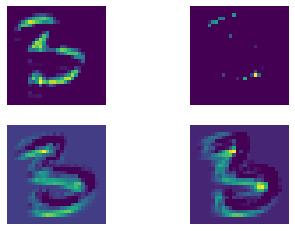


Conv_layer 2 maps training: 


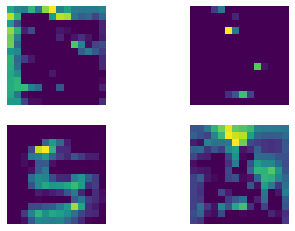


Conv layer 1 maps testing: 


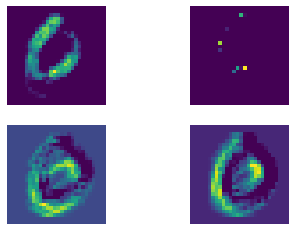


Conv_layer 2 maps testing: 


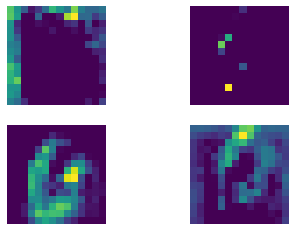

Epoch [9], train_loss: 0.3250,train_acc: 0.1020,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


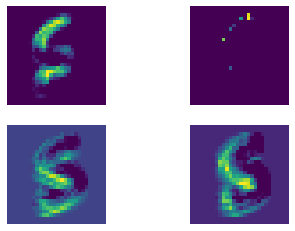


Conv_layer 2 maps training: 


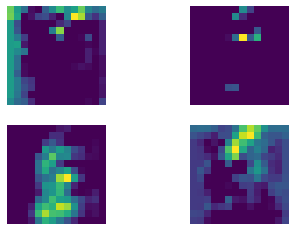


Conv layer 1 maps testing: 


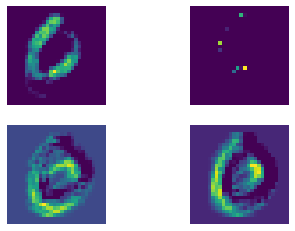


Conv_layer 2 maps testing: 


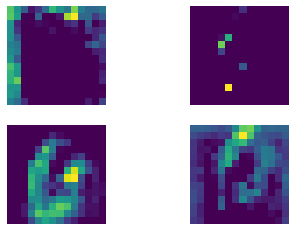

Epoch [10], train_loss: 0.3249,train_acc: 0.1020,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


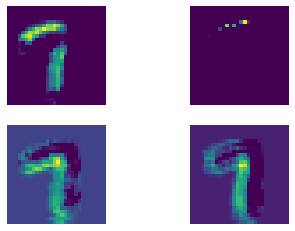


Conv_layer 2 maps training: 


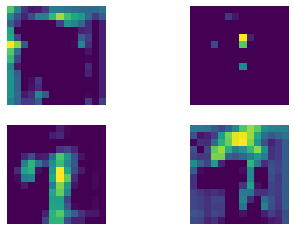


Conv layer 1 maps testing: 


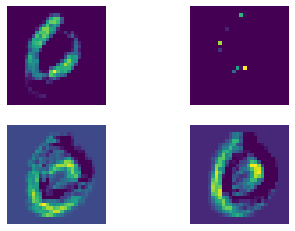


Conv_layer 2 maps testing: 


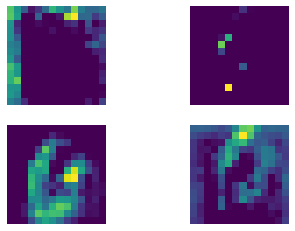

Epoch [11], train_loss: 0.3249,train_acc: 0.1020,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


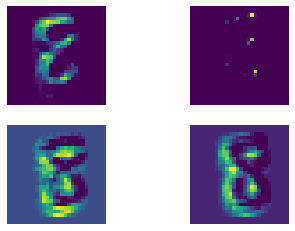


Conv_layer 2 maps training: 


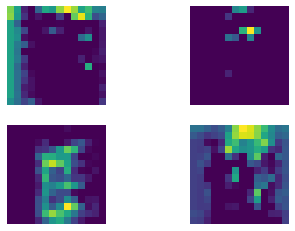


Conv layer 1 maps testing: 


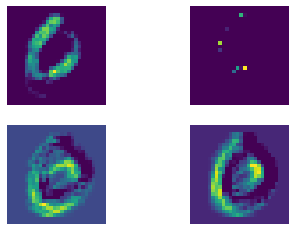


Conv_layer 2 maps testing: 


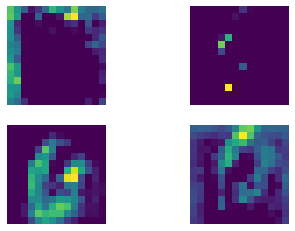

Epoch [12], train_loss: 0.3249,train_acc: 0.1020,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


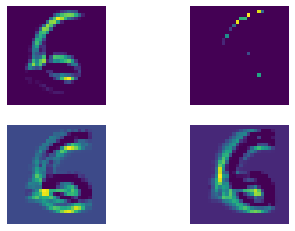


Conv_layer 2 maps training: 


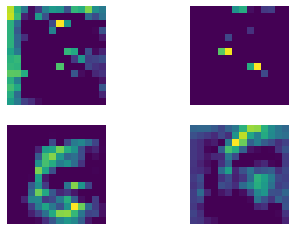


Conv layer 1 maps testing: 


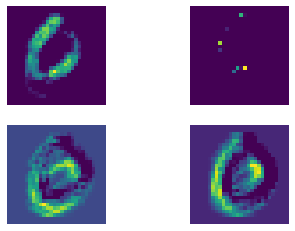


Conv_layer 2 maps testing: 


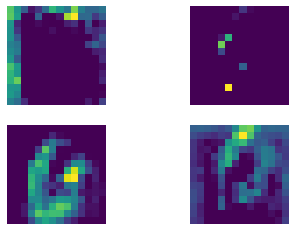

Epoch [13], train_loss: 0.3249,train_acc: 0.1020,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


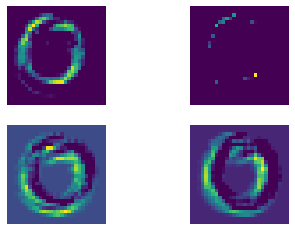


Conv_layer 2 maps training: 


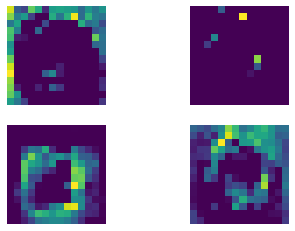


Conv layer 1 maps testing: 


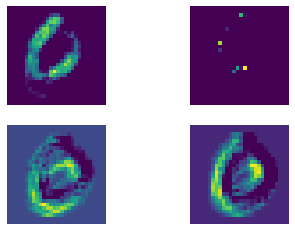


Conv_layer 2 maps testing: 


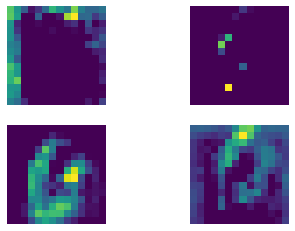

Epoch [14], train_loss: 0.3249,train_acc: 0.1020,test_loss: 0.3255,test_acc: 0.1000

Conv layer 1 maps training: 


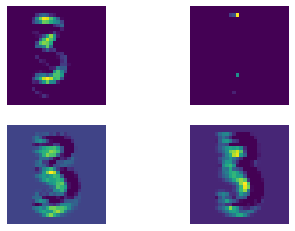


Conv_layer 2 maps training: 


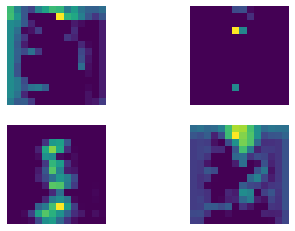


Conv layer 1 maps testing: 


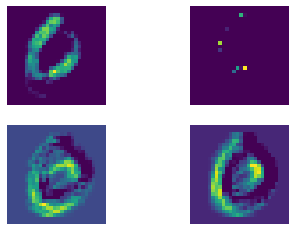


Conv_layer 2 maps testing: 


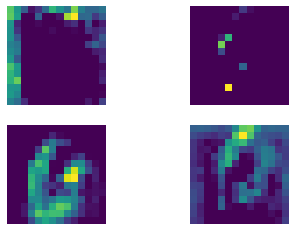

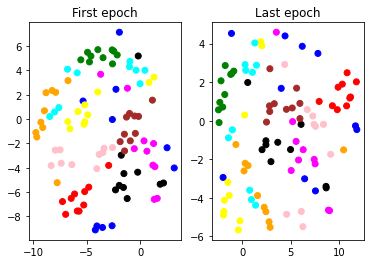

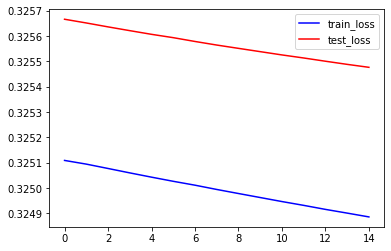

In [245]:
#Momentum
model_2 = CNN()
optimizer_2 = optim.SGD(model_2.parameters(),lr=0.001,momentum=0.9)
history_2 = fit(epochs=15,model=model_2,train_loader=train_loader2,test_loader=test_loader,optimizer=optimizer_2)
plot_loss(history_2)

C:\Users\aksha\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0], train_loss: 0.3234,train_acc: 0.1390,test_loss: 0.3199,test_acc: 0.2100

Conv layer 1 maps training: 


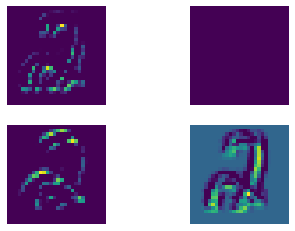


Conv_layer 2 maps training: 


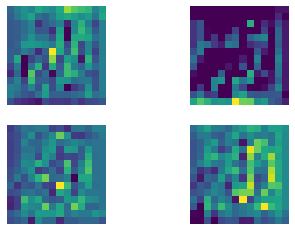


Conv layer 1 maps testing: 


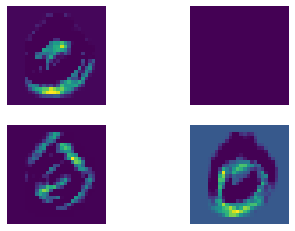


Conv_layer 2 maps testing: 


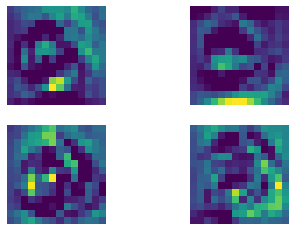

Epoch [1], train_loss: 0.3111,train_acc: 0.3190,test_loss: 0.2977,test_acc: 0.5100

Conv layer 1 maps training: 


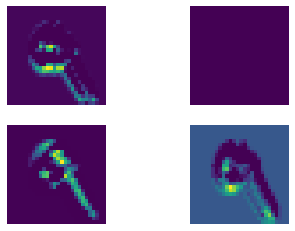


Conv_layer 2 maps training: 


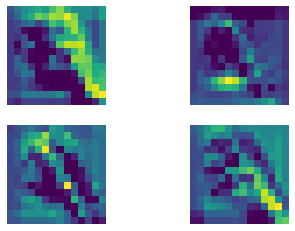


Conv layer 1 maps testing: 


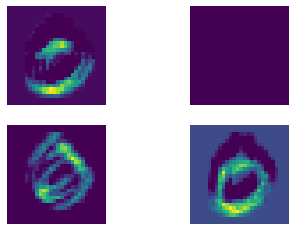


Conv_layer 2 maps testing: 


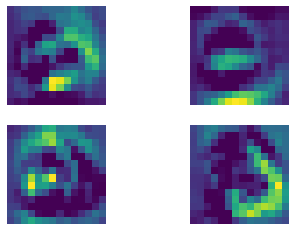

Epoch [2], train_loss: 0.2770,train_acc: 0.5350,test_loss: 0.2493,test_acc: 0.6800

Conv layer 1 maps training: 


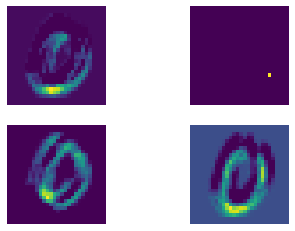


Conv_layer 2 maps training: 


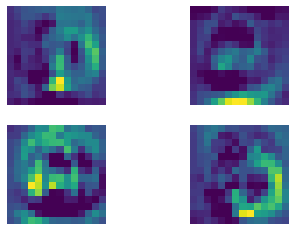


Conv layer 1 maps testing: 


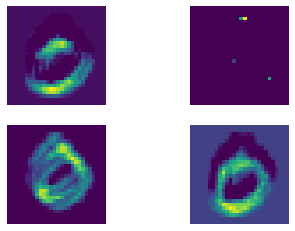


Conv_layer 2 maps testing: 


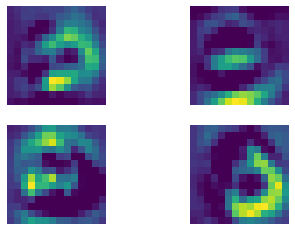

Epoch [3], train_loss: 0.2255,train_acc: 0.6300,test_loss: 0.1922,test_acc: 0.7500

Conv layer 1 maps training: 


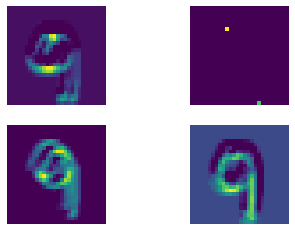


Conv_layer 2 maps training: 


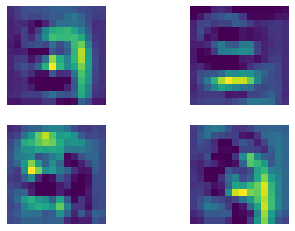


Conv layer 1 maps testing: 


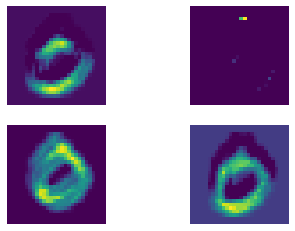


Conv_layer 2 maps testing: 


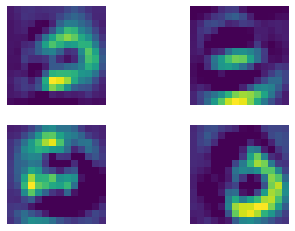

Epoch [4], train_loss: 0.1727,train_acc: 0.7320,test_loss: 0.1379,test_acc: 0.8100

Conv layer 1 maps training: 


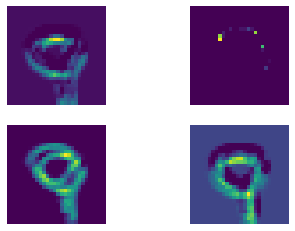


Conv_layer 2 maps training: 


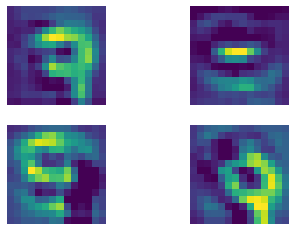


Conv layer 1 maps testing: 


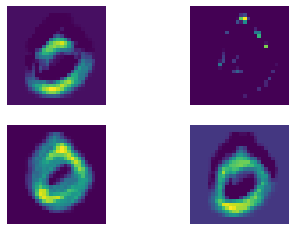


Conv_layer 2 maps testing: 


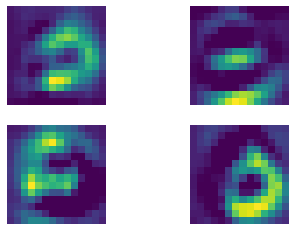

Epoch [5], train_loss: 0.1333,train_acc: 0.8010,test_loss: 0.1036,test_acc: 0.8600

Conv layer 1 maps training: 


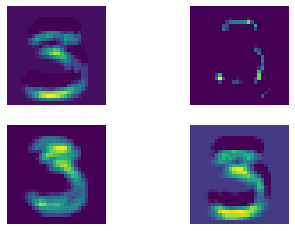


Conv_layer 2 maps training: 


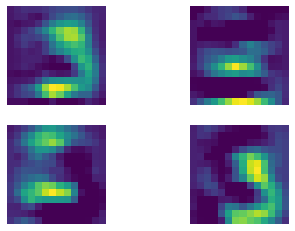


Conv layer 1 maps testing: 


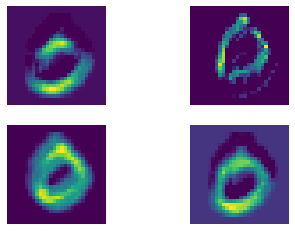


Conv_layer 2 maps testing: 


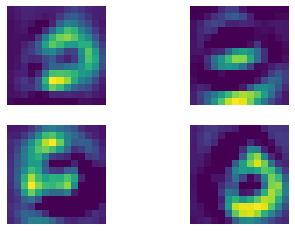

Epoch [6], train_loss: 0.1082,train_acc: 0.8230,test_loss: 0.0819,test_acc: 0.8400

Conv layer 1 maps training: 


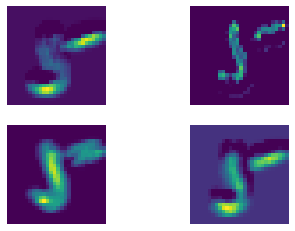


Conv_layer 2 maps training: 


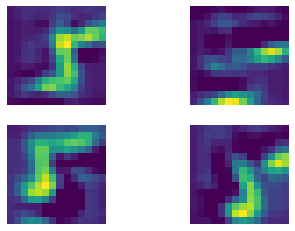


Conv layer 1 maps testing: 


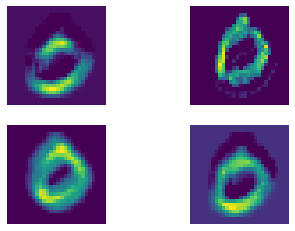


Conv_layer 2 maps testing: 


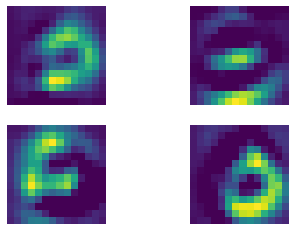

Epoch [7], train_loss: 0.0912,train_acc: 0.8350,test_loss: 0.0669,test_acc: 0.9200

Conv layer 1 maps training: 


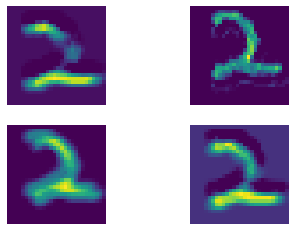


Conv_layer 2 maps training: 


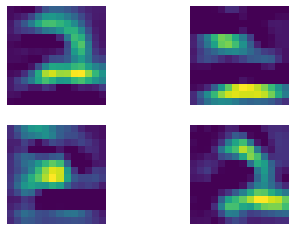


Conv layer 1 maps testing: 


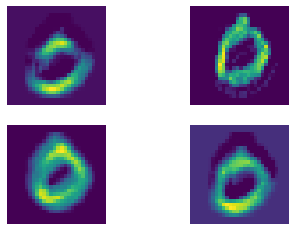


Conv_layer 2 maps testing: 


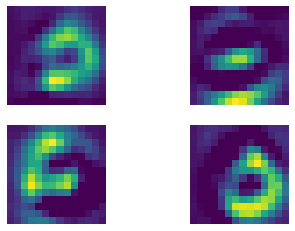

Epoch [8], train_loss: 0.0816,train_acc: 0.8550,test_loss: 0.0563,test_acc: 0.9000

Conv layer 1 maps training: 


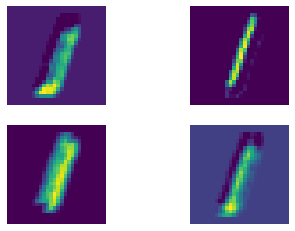


Conv_layer 2 maps training: 


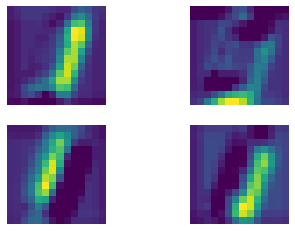


Conv layer 1 maps testing: 


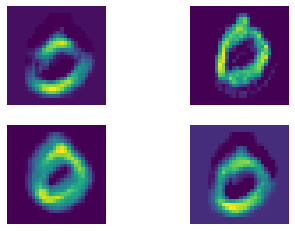


Conv_layer 2 maps testing: 


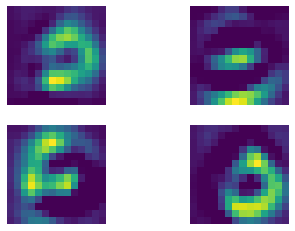

Epoch [9], train_loss: 0.0734,train_acc: 0.8690,test_loss: 0.0488,test_acc: 0.9100

Conv layer 1 maps training: 


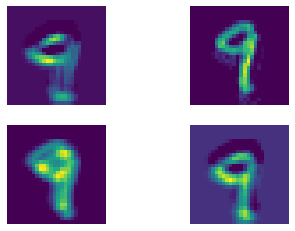


Conv_layer 2 maps training: 


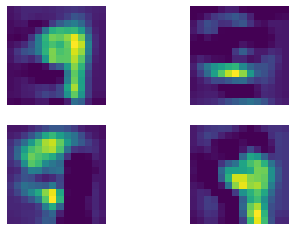


Conv layer 1 maps testing: 


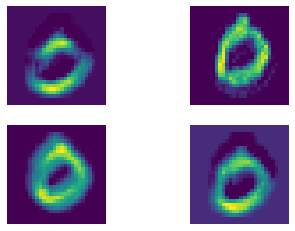


Conv_layer 2 maps testing: 


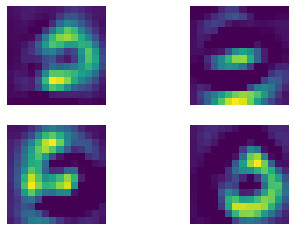

Epoch [10], train_loss: 0.0678,train_acc: 0.8830,test_loss: 0.0428,test_acc: 0.9200

Conv layer 1 maps training: 


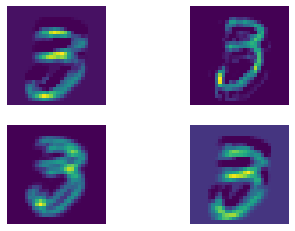


Conv_layer 2 maps training: 


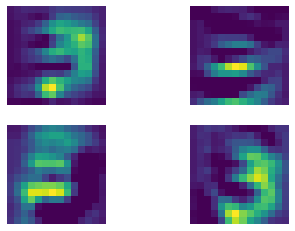


Conv layer 1 maps testing: 


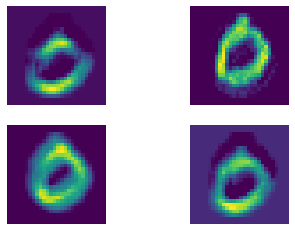


Conv_layer 2 maps testing: 


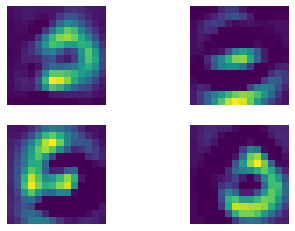

Epoch [11], train_loss: 0.0611,train_acc: 0.8850,test_loss: 0.0427,test_acc: 0.9300

Conv layer 1 maps training: 


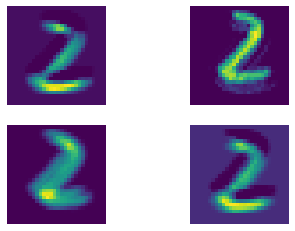


Conv_layer 2 maps training: 


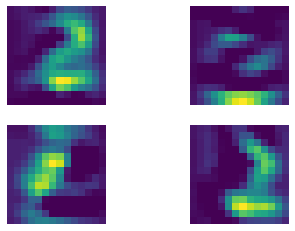


Conv layer 1 maps testing: 


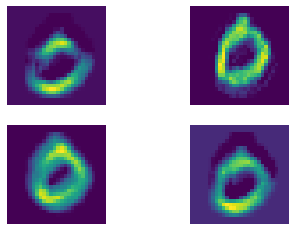


Conv_layer 2 maps testing: 


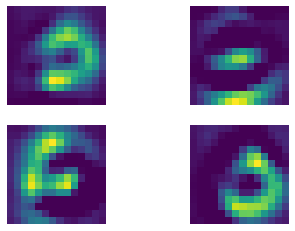

Epoch [12], train_loss: 0.0579,train_acc: 0.9010,test_loss: 0.0344,test_acc: 0.9600

Conv layer 1 maps training: 


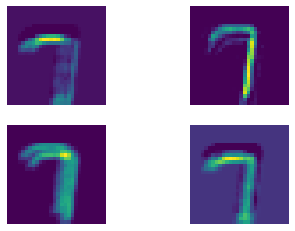


Conv_layer 2 maps training: 


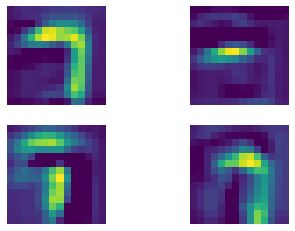


Conv layer 1 maps testing: 


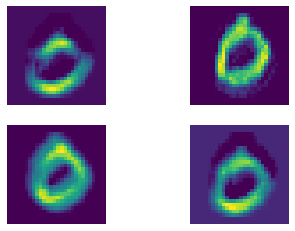


Conv_layer 2 maps testing: 


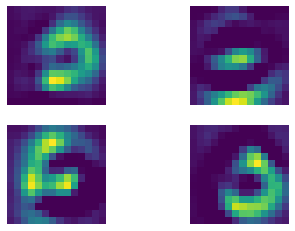

Epoch [13], train_loss: 0.0531,train_acc: 0.9060,test_loss: 0.0361,test_acc: 0.9300

Conv layer 1 maps training: 


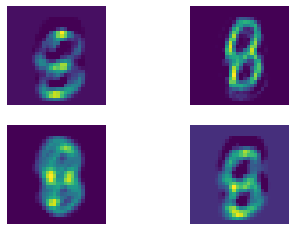


Conv_layer 2 maps training: 


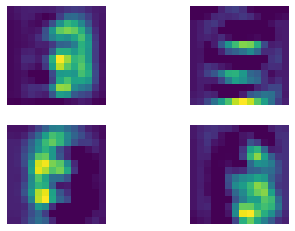


Conv layer 1 maps testing: 


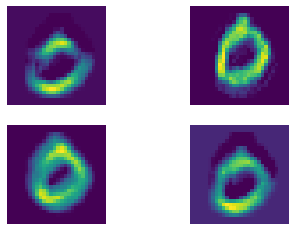


Conv_layer 2 maps testing: 


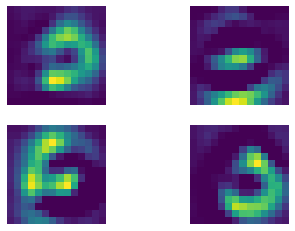

Epoch [14], train_loss: 0.0517,train_acc: 0.9100,test_loss: 0.0291,test_acc: 0.9500

Conv layer 1 maps training: 


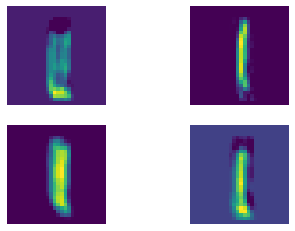


Conv_layer 2 maps training: 


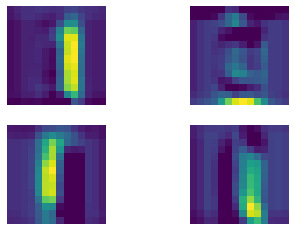


Conv layer 1 maps testing: 


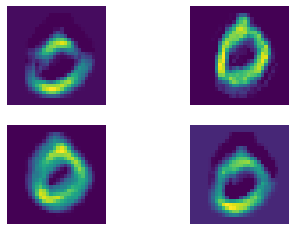


Conv_layer 2 maps testing: 


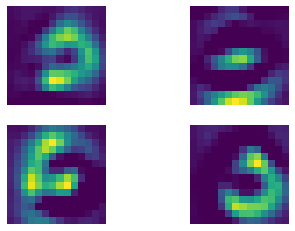

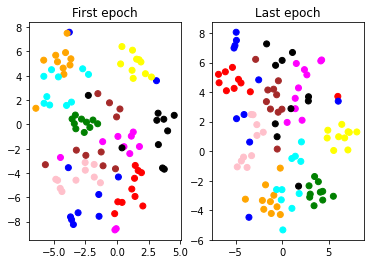

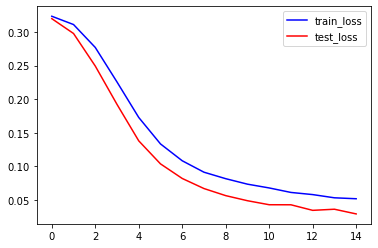

In [249]:
#RMSProp
model_3 = CNN()
optimizer_3 = optim.RMSprop(model_3.parameters(),alpha = 0.9,lr=0.001)
history_3 = fit(epochs=15,model=model_3,train_loader=train_loader2,test_loader=test_loader,optimizer=optimizer_3)
plot_loss(history_3)

In [231]:
def fit(epochs,model,train_loader,test_loader,optimizer):
    history = []
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []

        for batch in train_loader:           
            loss,acc = model.training_step(batch)
            train_losses.append(loss)
            train_accuracies.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        
        model.eval()
        for batch in test_loader:   
            test_loss,test_acc = model.test_step(batch)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)     
        
        result = {}
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        result['test_loss'] = torch.stack(test_losses).mean().item()
        result['test_acc'] = torch.stack(test_accuracies).mean().item()
        model.epoch_end(epoch,result)

        
        history.append(result)
    return history

## Comparison of Hw4 and Hw5

### SGD Outputs

#### Training vs Testing Comparison

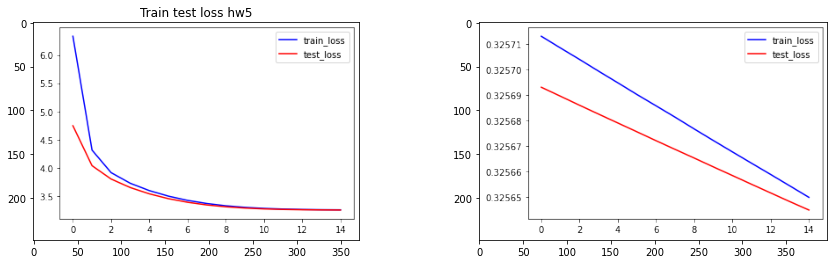

In [263]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
img1 = img.imread('Plots/train-test-sgd.png')
img2 = img.imread('Plots/pytorch/train-test-sgd.png')
ax1.imshow(img1)
ax1.set_title("Train test loss hw4")
ax1.set_title("Train test loss hw5")
ax2.imshow(img2)


#### Activation maps Comparison

Activation map comparison for 1st epoch




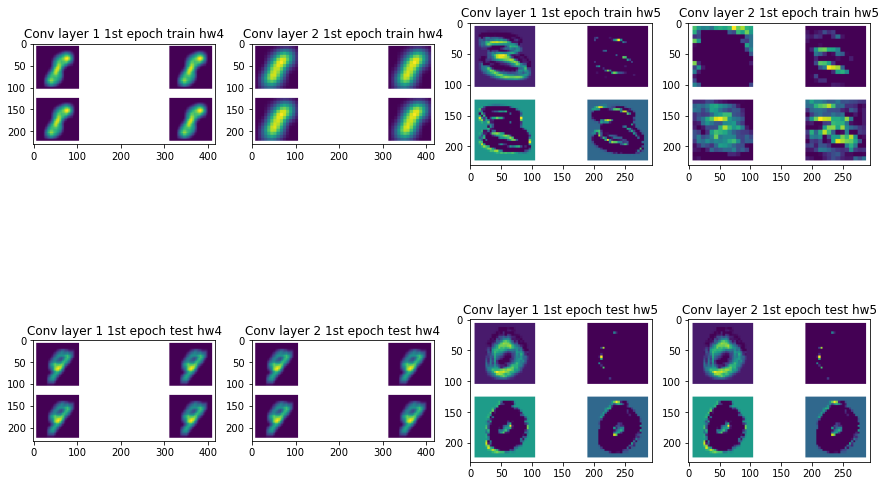


Activation map comparison for last epoch




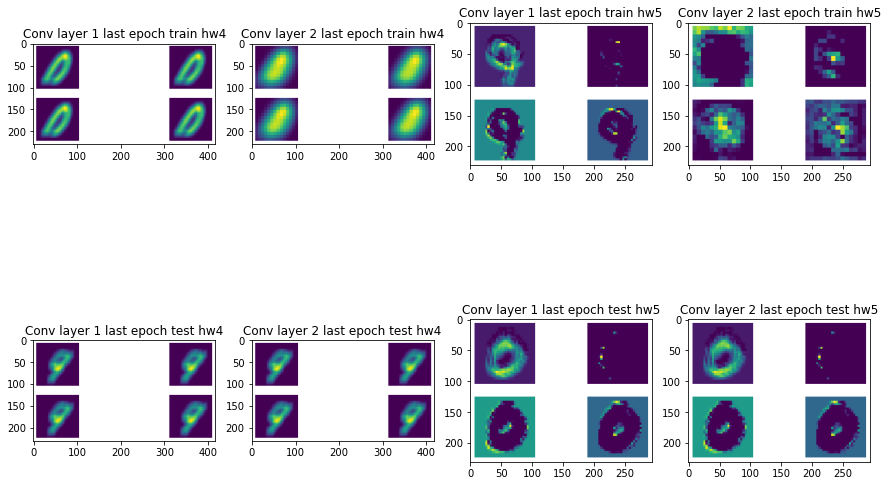

In [278]:
#Train
print("Activation map comparison for 1st epoch")
print("\n")
fig,ax = plt.subplots(2,4,figsize=(15,10))
img1 = img.imread('Plots/convlayer1sgd1stepoch.png')
img2 = img.imread('Plots/convlayer2sgd1stepoch.png')
img3 = img.imread('Plots/convlayer1testsgd1stepoch.png')
img4 = img.imread('Plots/convlayer1testsgd1stepoch.png')
img5 = img.imread('Plots/pytorch/convlayer1sgd1stepoch.png')
img6 = img.imread('Plots/pytorch/convlayer2sgd1stepoch.png')
img7 = img.imread('Plots/pytorch/convlayer1testsgd1stepoch.png')
img8 = img.imread('Plots/pytorch/convlayer1testsgd1stepoch.png')

ax[0,0].set_title("Conv layer 1 1st epoch train hw4")
ax[0,0].imshow(img1)
ax[0,1].set_title("Conv layer 2 1st epoch train hw4")
ax[0,1].imshow(img2)
ax[1,0].set_title("Conv layer 1 1st epoch test hw4")
ax[1,0].imshow(img3)
ax[1,1].set_title("Conv layer 2 1st epoch test hw4")
ax[1,1].imshow(img4)
ax[0,2].set_title("Conv layer 1 1st epoch train hw5")
ax[0,2].imshow(img5)
ax[0,3].set_title("Conv layer 2 1st epoch train hw5")
ax[0,3].imshow(img6)
ax[1,2].set_title("Conv layer 1 1st epoch test hw5")
ax[1,2].imshow(img7)
ax[1,3].set_title("Conv layer 2 1st epoch test hw5")
ax[1,3].imshow(img8)
plt.show()

#test
print("\nActivation map comparison for last epoch")
print("\n")
fig,ax = plt.subplots(2,4,figsize=(15,10))
img1 = img.imread('Plots/convlayer1sgd15thepoch.png')
img2 = img.imread('Plots/convlayer2sgd15thepoch.png')
img3 = img.imread('Plots/convlayer1testsgd15thepoch.png')
img4 = img.imread('Plots/convlayer1testsgd15thepoch.png')
img5 = img.imread('Plots/pytorch/convlayer1sgd15thepoch.png')
img6 = img.imread('Plots/pytorch/convlayer2sgd15thepoch.png')
img7 = img.imread('Plots/pytorch/convlayer1testsgd15thepoch.png')
img8 = img.imread('Plots/pytorch/convlayer1testsgd15thepoch.png')

ax[0,0].set_title("Conv layer 1 last epoch train hw4")
ax[0,0].imshow(img1)
ax[0,1].set_title("Conv layer 2 last epoch train hw4")
ax[0,1].imshow(img2)
ax[1,0].set_title("Conv layer 1 last epoch test hw4")
ax[1,0].imshow(img3)
ax[1,1].set_title("Conv layer 2 last epoch test hw4")
ax[1,1].imshow(img4)
ax[0,2].set_title("Conv layer 1 last epoch train hw5")
ax[0,2].imshow(img5)
ax[0,3].set_title("Conv layer 2 last epoch train hw5")
ax[0,3].imshow(img6)
ax[1,2].set_title("Conv layer 1 last epoch test hw5")
ax[1,2].imshow(img7)
ax[1,3].set_title("Conv layer 2 last epoch test hw5")
ax[1,3].imshow(img8)
plt.show()


#### TSNE comparison

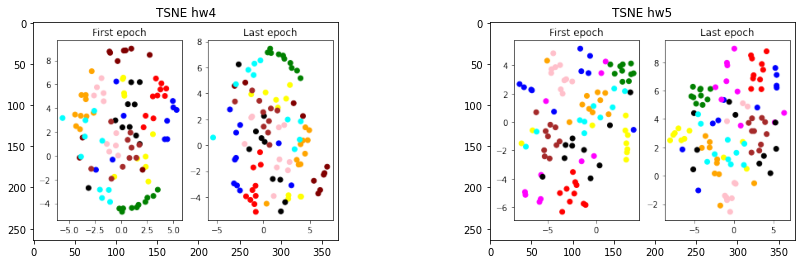

In [280]:
img1 = img.imread('Plots/tsne-sgd.png')
img2 = img.imread('Plots/pytorch/tsne-sgd.png')
fig,ax = plt.subplots(1,2,figsize = (15,4))

ax[0].set_title('TSNE hw4')
ax[0].imshow(img1)
ax[1].set_title('TSNE hw5')
ax[1].imshow(img2)
plt.show()

#### Model Accuracy
AFTER 15 EPOCHS

Hw4- Train Loss:  3.25541, Train accuracy:  0.06899, Test loss:  3.2519,Test accuracy:  0.11

Hw5- Train_Loss: 0.3258, Train accuracy: 0.0940, Test_loss: 0.3255, Test accuracy: 0.1000

### Momentum Outputs

#### Training vs Testing Comparison

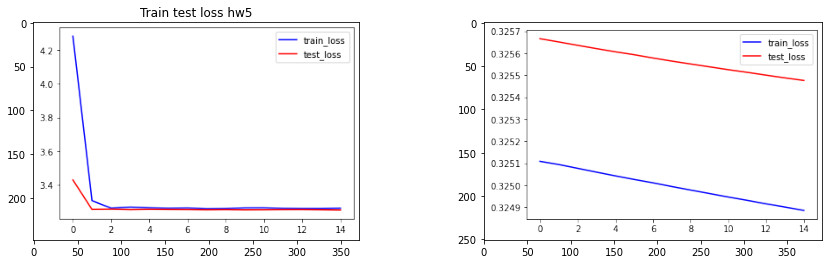

In [281]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
img1 = img.imread('Plots/train-test-momentum.png')
img2 = img.imread('Plots/pytorch/train-test-momentum.png')
ax1.imshow(img1)
ax1.set_title("Train test loss hw4")
ax1.set_title("Train test loss hw5")
ax2.imshow(img2)


#### Activation maps Comparison

Activation map comparison for 1st epoch




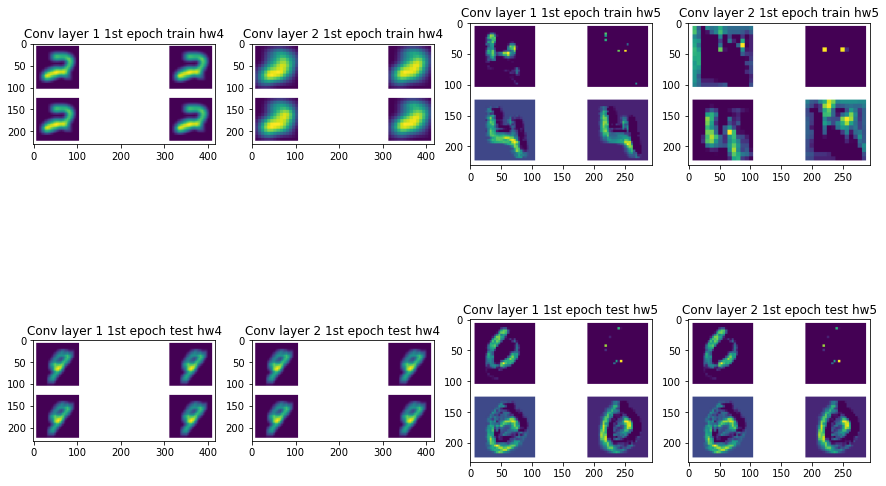


Activation map comparison for last epoch




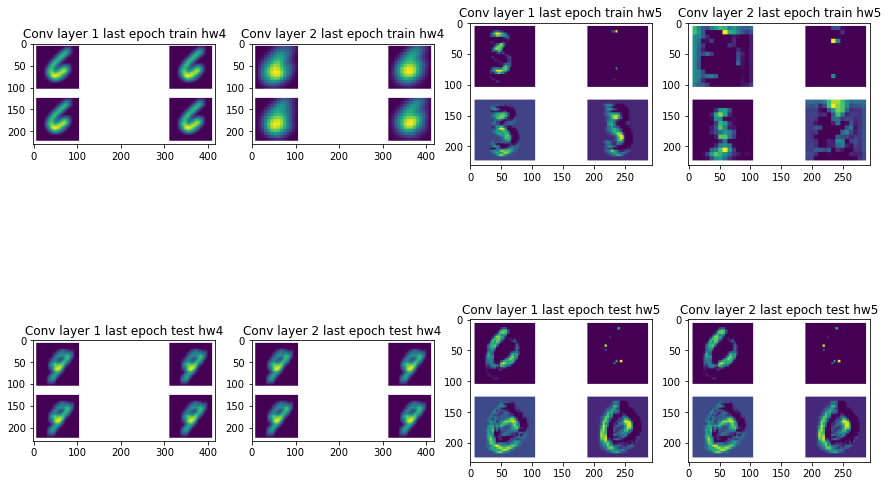

In [282]:
#Train
print("Activation map comparison for 1st epoch")
print("\n")
fig,ax = plt.subplots(2,4,figsize=(15,10))
img1 = img.imread('Plots/convlayer1mom1stepoch.png')
img2 = img.imread('Plots/convlayer2mom1stepoch.png')
img3 = img.imread('Plots/convlayer1testmom1stepoch.png')
img4 = img.imread('Plots/convlayer1testmom1stepoch.png')
img5 = img.imread('Plots/pytorch/convlayer1mom1stepoch.png')
img6 = img.imread('Plots/pytorch/convlayer2mom1stepoch.png')
img7 = img.imread('Plots/pytorch/convlayer1testmom1stepoch.png')
img8 = img.imread('Plots/pytorch/convlayer1testmom1stepoch.png')

ax[0,0].set_title("Conv layer 1 1st epoch train hw4")
ax[0,0].imshow(img1)
ax[0,1].set_title("Conv layer 2 1st epoch train hw4")
ax[0,1].imshow(img2)
ax[1,0].set_title("Conv layer 1 1st epoch test hw4")
ax[1,0].imshow(img3)
ax[1,1].set_title("Conv layer 2 1st epoch test hw4")
ax[1,1].imshow(img4)
ax[0,2].set_title("Conv layer 1 1st epoch train hw5")
ax[0,2].imshow(img5)
ax[0,3].set_title("Conv layer 2 1st epoch train hw5")
ax[0,3].imshow(img6)
ax[1,2].set_title("Conv layer 1 1st epoch test hw5")
ax[1,2].imshow(img7)
ax[1,3].set_title("Conv layer 2 1st epoch test hw5")
ax[1,3].imshow(img8)
plt.show()

#test
print("\nActivation map comparison for last epoch")
print("\n")
fig,ax = plt.subplots(2,4,figsize=(15,10))
img1 = img.imread('Plots/convlayer1mom15thepoch.png')
img2 = img.imread('Plots/convlayer2mom15thepoch.png')
img3 = img.imread('Plots/convlayer1testmom15thepoch.png')
img4 = img.imread('Plots/convlayer1testmom15thepoch.png')
img5 = img.imread('Plots/pytorch/convlayer1mom15thepoch.png')
img6 = img.imread('Plots/pytorch/convlayer2mom15thepoch.png')
img7 = img.imread('Plots/pytorch/convlayer1testmom15thepoch.png')
img8 = img.imread('Plots/pytorch/convlayer1testmom15thepoch.png')

ax[0,0].set_title("Conv layer 1 last epoch train hw4")
ax[0,0].imshow(img1)
ax[0,1].set_title("Conv layer 2 last epoch train hw4")
ax[0,1].imshow(img2)
ax[1,0].set_title("Conv layer 1 last epoch test hw4")
ax[1,0].imshow(img3)
ax[1,1].set_title("Conv layer 2 last epoch test hw4")
ax[1,1].imshow(img4)
ax[0,2].set_title("Conv layer 1 last epoch train hw5")
ax[0,2].imshow(img5)
ax[0,3].set_title("Conv layer 2 last epoch train hw5")
ax[0,3].imshow(img6)
ax[1,2].set_title("Conv layer 1 last epoch test hw5")
ax[1,2].imshow(img7)
ax[1,3].set_title("Conv layer 2 last epoch test hw5")
ax[1,3].imshow(img8)
plt.show()


#### TSNE Comparison

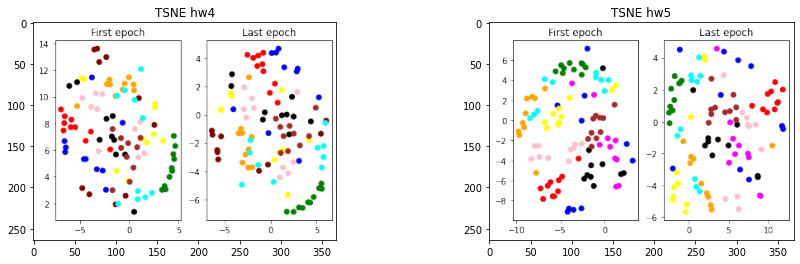

In [283]:
img1 = img.imread('Plots/tsne-momentum.png')
img2 = img.imread('Plots/pytorch/tsne-momentum.png')
fig,ax = plt.subplots(1,2,figsize = (15,4))

ax[0].set_title('TSNE hw4')
ax[0].imshow(img1)
ax[1].set_title('TSNE hw5')
ax[1].imshow(img2)
plt.show()

#### Accuracy Comparison

AFTER 15 EPOCHS 

Hw4 - Train Loss:  3.2620, Train accuracy 0.072, Test loss:  3.2516, Test accuracy:  0.12

Hw5 - Train_loss: 0.3249, Train_acc: 0.1020, Test_loss: 0.3255, Test_acc: 0.1000

### RMSProp Outputs

#### Training vs Testing Comparison

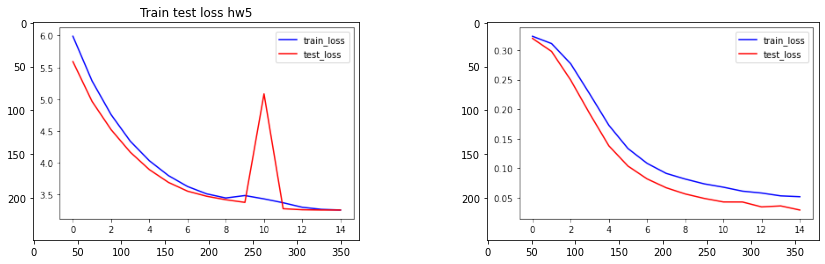

In [6]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
img1 = img.imread('Plots/train-test-rms.png')
img2 = img.imread('Plots/pytorch/train-test-rms.png')
ax1.imshow(img1)
ax1.set_title("Train test loss hw4")
ax1.set_title("Train test loss hw5")
ax2.imshow(img2)


#### Activation maps comparison

Activation map comparison for 1st epoch




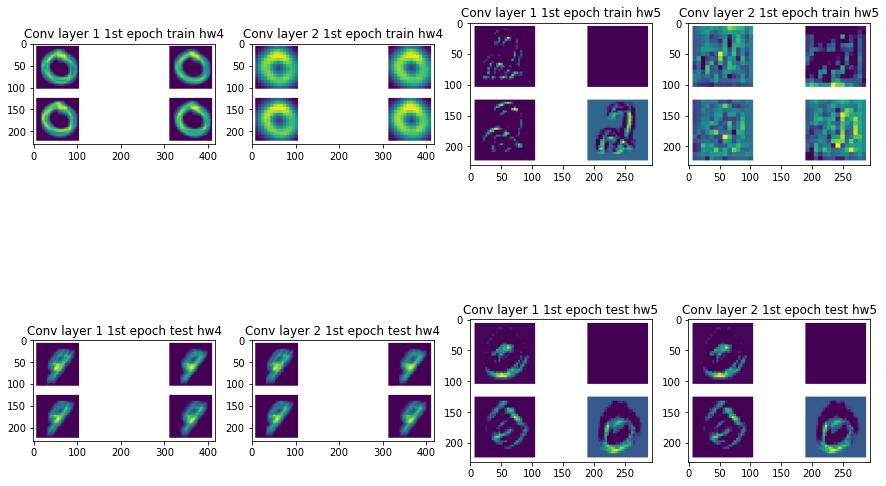


Activation map comparison for last epoch




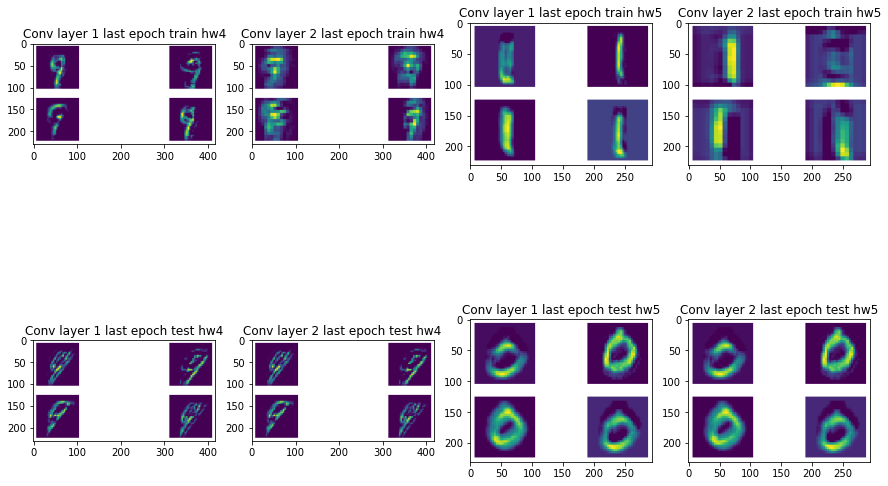

In [7]:
#Train
print("Activation map comparison for 1st epoch")
print("\n")
fig,ax = plt.subplots(2,4,figsize=(15,10))
img1 = img.imread('Plots/convlayer1rms1stepoch.png')
img2 = img.imread('Plots/convlayer2rms1stepoch.png')
img3 = img.imread('Plots/convlayer1testrms1stepoch.png')
img4 = img.imread('Plots/convlayer1testrms1stepoch.png')
img5 = img.imread('Plots/pytorch/convlayer1rms1stepoch.png')
img6 = img.imread('Plots/pytorch/convlayer2rms1stepoch.png')
img7 = img.imread('Plots/pytorch/convlayer1testrms1stepoch.png')
img8 = img.imread('Plots/pytorch/convlayer1testrms1stepoch.png')

ax[0,0].set_title("Conv layer 1 1st epoch train hw4")
ax[0,0].imshow(img1)
ax[0,1].set_title("Conv layer 2 1st epoch train hw4")
ax[0,1].imshow(img2)
ax[1,0].set_title("Conv layer 1 1st epoch test hw4")
ax[1,0].imshow(img3)
ax[1,1].set_title("Conv layer 2 1st epoch test hw4")
ax[1,1].imshow(img4)
ax[0,2].set_title("Conv layer 1 1st epoch train hw5")
ax[0,2].imshow(img5)
ax[0,3].set_title("Conv layer 2 1st epoch train hw5")
ax[0,3].imshow(img6)
ax[1,2].set_title("Conv layer 1 1st epoch test hw5")
ax[1,2].imshow(img7)
ax[1,3].set_title("Conv layer 2 1st epoch test hw5")
ax[1,3].imshow(img8)
plt.show()

#test
print("\nActivation map comparison for last epoch")
print("\n")
fig,ax = plt.subplots(2,4,figsize=(15,10))
img1 = img.imread('Plots/convlayer1rms15thepoch.png')
img2 = img.imread('Plots/convlayer2rms15thepoch.png')
img3 = img.imread('Plots/convlayer1testrms15thepoch.png')
img4 = img.imread('Plots/convlayer1testrms15thepoch.png')
img5 = img.imread('Plots/pytorch/convlayer1rms15thepoch.png')
img6 = img.imread('Plots/pytorch/convlayer2rms15thepoch.png')
img7 = img.imread('Plots/pytorch/convlayer1testrms15thepoch.png')
img8 = img.imread('Plots/pytorch/convlayer1testrms15thepoch.png')

ax[0,0].set_title("Conv layer 1 last epoch train hw4")
ax[0,0].imshow(img1)
ax[0,1].set_title("Conv layer 2 last epoch train hw4")
ax[0,1].imshow(img2)
ax[1,0].set_title("Conv layer 1 last epoch test hw4")
ax[1,0].imshow(img3)
ax[1,1].set_title("Conv layer 2 last epoch test hw4")
ax[1,1].imshow(img4)
ax[0,2].set_title("Conv layer 1 last epoch train hw5")
ax[0,2].imshow(img5)
ax[0,3].set_title("Conv layer 2 last epoch train hw5")
ax[0,3].imshow(img6)
ax[1,2].set_title("Conv layer 1 last epoch test hw5")
ax[1,2].imshow(img7)
ax[1,3].set_title("Conv layer 2 last epoch test hw5")
ax[1,3].imshow(img8)
plt.show()


#### TSNE Comparison

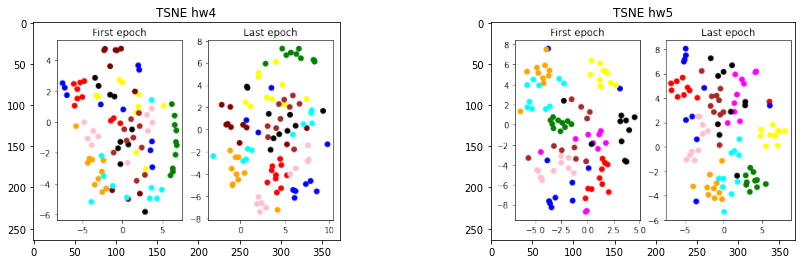

In [8]:
img1 = img.imread('Plots/tsne-rms.png')
img2 = img.imread('Plots/pytorch/tsne-rms.png')
fig,ax = plt.subplots(1,2,figsize = (15,4))

ax[0].set_title('TSNE hw4')
ax[0].imshow(img1)
ax[1].set_title('TSNE hw5')
ax[1].imshow(img2)
plt.show()

#### Accuracy Comparison

AFTER 15 EPOCHS 

Hw4 - Train Loss:  3.258176508609403, Train accuracy: 0.1, Test loss:  3.257846247405147, Test accuracy:  0.1

Hw5 - train_loss: 0.0517, train_acc: 0.9100, test_loss: 0.0291, test_acc: 0.9500

### With dropout

In [232]:
#CNN Class with dropout without batch norm
class CNN_D(nn.Module):
    def __init__(self,dropout):
        super(CNN_D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=4,kernel_size=5,stride=1,padding=2)
        self.conv2 = nn.Conv2d(in_channels=4,out_channels=4,kernel_size=5,stride=1,padding=2)
        self.linear1 = nn.Linear(196,49)
        self.linear2 = nn.Linear(49,10)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x):
        conv_output1 = self.conv1(x)
        conv_output1 = F.relu(conv_output1)
        max_pool1 = F.max_pool2d(conv_output1,kernel_size=2,stride=2)
        conv_output2 = self.conv2(max_pool1)
        conv_output2 = F.relu(conv_output2)
        max_pool2 = F.max_pool2d(conv_output2,kernel_size=2,stride=2)
        flattened = torch.flatten(max_pool2,1)
        mlp1 = self.linear1(flattened)
        mlp1 = F.relu(mlp1)
        mlp1 = self.dropout(mlp1)
        mlp2 = self.linear2(mlp1)
        output = F.softmax(mlp2)
        return output,conv_output1,conv_output2,flattened
    
    def accuracy(self,outputs, labels):
        _, preds = torch.max(outputs, dim=1)   
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
    
    def plot_loss(self,epochs,train_loss,train_accuracy,test_loss,test_accuracy):
        iters = range(epochs)
        plt.plot(iters,train_loss,'-b',label='train_loss')
        plt.plot(iters,train_accuracy,'-y',label='train_accuracy')
        plt.plot(iters,test_loss,'-r',label='test_loss')
        plt.plot(iters,test_accuracy,'-g',label='test_accuracy')
        plt.show()
    
    def training_step(self, batch):
        images, labels = batch 
#         for i in range(len(labels)):
#             labels[i] = F.one_hot(labels[i],10)
            
        out,conv1,conv2,flattened = self.forward(images)                  # Generate predictions
        loss = F.binary_cross_entropy(out,F.one_hot(labels,10).float() ) # Calculate loss
        acc = self.accuracy(out,labels)
        return loss,acc
    
    def test_step(self,batch):
        
        image,label = batch
        out,conv1,conv2,flattened = self.forward(image)
        loss = F.binary_cross_entropy(out,F.one_hot(label,10).float())
        acc = self.accuracy(out,label)
        return loss,acc
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f},train_acc: {:.4f},test_loss: {:.4f},test_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'],result['test_loss'],result['test_acc']))
        
    



C:\Users\aksha\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0], train_loss: 0.2975,train_acc: 0.2960,test_loss: 0.2331,test_acc: 0.6400
Epoch [1], train_loss: 0.2004,train_acc: 0.5840,test_loss: 0.1334,test_acc: 0.8400
Epoch [2], train_loss: 0.1448,train_acc: 0.6990,test_loss: 0.0937,test_acc: 0.8400
Epoch [3], train_loss: 0.1237,train_acc: 0.7390,test_loss: 0.0797,test_acc: 0.8600
Epoch [4], train_loss: 0.1029,train_acc: 0.8000,test_loss: 0.0694,test_acc: 0.8700
Epoch [5], train_loss: 0.0962,train_acc: 0.8130,test_loss: 0.0613,test_acc: 0.9300
Epoch [6], train_loss: 0.0884,train_acc: 0.8280,test_loss: 0.0695,test_acc: 0.8900
Epoch [7], train_loss: 0.0818,train_acc: 0.8290,test_loss: 0.0495,test_acc: 0.9300
Epoch [8], train_loss: 0.0761,train_acc: 0.8480,test_loss: 0.0424,test_acc: 0.9300
Epoch [9], train_loss: 0.0656,train_acc: 0.8760,test_loss: 0.0467,test_acc: 0.9100
Epoch [10], train_loss: 0.0646,train_acc: 0.8650,test_loss: 0.0323,test_acc: 0.9500
Epoch [11], train_loss: 0.0663,train_acc: 0.8750,test_loss: 0.0319,test_acc: 0.9500
Ep

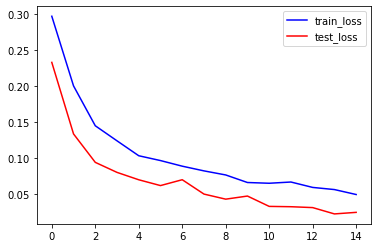

In [233]:
#Dropout = 0.2
model4 = CNN_D(dropout=0.2)
optimizer4 = optim.RMSprop(model4.parameters(),alpha = 0.9,lr=0.001)
history4 = fit(epochs=15,model=model4,train_loader=train_loader1,test_loader=test_loader,optimizer=optimizer4)
plot_loss(history4)

C:\Users\aksha\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0], train_loss: 0.3122,train_acc: 0.2520,test_loss: 0.2751,test_acc: 0.5800
Epoch [1], train_loss: 0.2497,train_acc: 0.4770,test_loss: 0.1778,test_acc: 0.7200
Epoch [2], train_loss: 0.1931,train_acc: 0.5810,test_loss: 0.1265,test_acc: 0.8300
Epoch [3], train_loss: 0.1625,train_acc: 0.6560,test_loss: 0.1024,test_acc: 0.8300
Epoch [4], train_loss: 0.1479,train_acc: 0.6850,test_loss: 0.0843,test_acc: 0.8800
Epoch [5], train_loss: 0.1284,train_acc: 0.7340,test_loss: 0.0714,test_acc: 0.9100
Epoch [6], train_loss: 0.1276,train_acc: 0.7500,test_loss: 0.0650,test_acc: 0.9000
Epoch [7], train_loss: 0.1115,train_acc: 0.7750,test_loss: 0.0537,test_acc: 0.9300
Epoch [8], train_loss: 0.1090,train_acc: 0.7720,test_loss: 0.0499,test_acc: 0.9300
Epoch [9], train_loss: 0.1073,train_acc: 0.7740,test_loss: 0.0454,test_acc: 0.9000
Epoch [10], train_loss: 0.0916,train_acc: 0.8100,test_loss: 0.0393,test_acc: 0.9300
Epoch [11], train_loss: 0.0894,train_acc: 0.8230,test_loss: 0.0331,test_acc: 0.9200
Ep

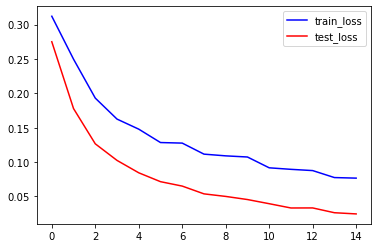

In [234]:
#Dropout = 0.5
model5 = CNN_D(dropout=0.5)
optimizer5 = optim.RMSprop(model5.parameters(),alpha = 0.9,lr=0.001)
history5 = fit(epochs=15,model=model5,train_loader=train_loader1,test_loader=test_loader,optimizer=optimizer5)
plot_loss(history5)

C:\Users\aksha\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0], train_loss: 0.3214,train_acc: 0.1540,test_loss: 0.3105,test_acc: 0.4500
Epoch [1], train_loss: 0.2991,train_acc: 0.2710,test_loss: 0.2680,test_acc: 0.6000
Epoch [2], train_loss: 0.2705,train_acc: 0.3410,test_loss: 0.2196,test_acc: 0.6800
Epoch [3], train_loss: 0.2523,train_acc: 0.3940,test_loss: 0.1948,test_acc: 0.7900
Epoch [4], train_loss: 0.2338,train_acc: 0.4340,test_loss: 0.1655,test_acc: 0.7500
Epoch [5], train_loss: 0.2251,train_acc: 0.4720,test_loss: 0.1496,test_acc: 0.8600
Epoch [6], train_loss: 0.2198,train_acc: 0.4600,test_loss: 0.1353,test_acc: 0.8600
Epoch [7], train_loss: 0.2093,train_acc: 0.4820,test_loss: 0.1250,test_acc: 0.8000
Epoch [8], train_loss: 0.2002,train_acc: 0.5140,test_loss: 0.1145,test_acc: 0.8300
Epoch [9], train_loss: 0.1970,train_acc: 0.5400,test_loss: 0.1128,test_acc: 0.9000
Epoch [10], train_loss: 0.1873,train_acc: 0.5500,test_loss: 0.0991,test_acc: 0.8900
Epoch [11], train_loss: 0.1823,train_acc: 0.5370,test_loss: 0.1004,test_acc: 0.9200
Ep

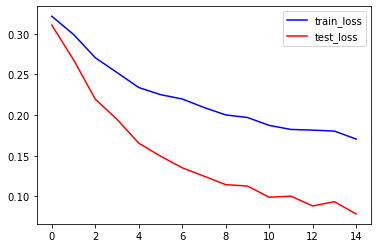

In [235]:
#Dropout = 0.8
model6 = CNN_D(dropout=0.8)
optimizer6 = optim.RMSprop(model6.parameters(),alpha = 0.9,lr=0.001)
history6 = fit(epochs=15,model=model6,train_loader=train_loader1,test_loader=test_loader,optimizer=optimizer6)
plot_loss(history6)

### Comparing losses for different dropout values

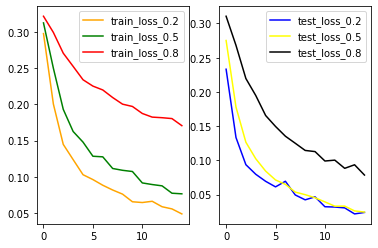

In [248]:
iters = range(15)
train_loss1 = []
train_loss2 = []
train_loss3 = []
test_loss1 = []
test_loss2 = []
test_loss3 = []
fig,(ax1,ax2) = plt.subplots(1,2)
for i in range(15):
    train_loss1.append(history4[i]['train_loss'])
    train_loss2.append(history5[i]['train_loss'])    
    train_loss3.append(history6[i]['train_loss']) 
    test_loss1.append(history4[i]['test_loss'])
    test_loss2.append(history5[i]['test_loss'])
    test_loss3.append(history6[i]['test_loss'])
ax1.plot(iters,train_loss1,'orange',label='train_loss_0.2')
ax1.plot(iters,train_loss2,'green',label='train_loss_0.5')
ax1.plot(iters,train_loss3,'red',label='train_loss_0.8')
ax2.plot(iters,test_loss1,'blue',label='test_loss_0.2')
ax2.plot(iters,test_loss2,'yellow',label='test_loss_0.5')
ax2.plot(iters,test_loss3,'black',label='test_loss_0.8')
ax1.legend()
ax2.legend()
plt.show()

As we increase the dropout value, the training loss does not descend as fast since the network requires more epochs to train.

## With batchnorm 

In [236]:
#CNN Class with dropout and with batch norm
class CNN_D_BN(nn.Module):
    def __init__(self,dropout):
        super(CNN_D_BN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=4,kernel_size=5,stride=1,padding=2)
        self.conv2 = nn.Conv2d(in_channels=4,out_channels=4,kernel_size=5,stride=1,padding=2)
        self.linear1 = nn.Linear(196,49)
        self.linear2 = nn.Linear(49,10)
        self.dropout = nn.Dropout(dropout)
        self.batchnorm = nn.BatchNorm1d(49)
        
    def forward(self,x):
        conv_output1 = self.conv1(x)
        conv_output1 = F.relu(conv_output1)
        max_pool1 = F.max_pool2d(conv_output1,kernel_size=2,stride=2)
        conv_output2 = self.conv2(max_pool1)
        conv_output2 = F.relu(conv_output2)
        max_pool2 = F.max_pool2d(conv_output2,kernel_size=2,stride=2)
        flattened = torch.flatten(max_pool2,1)
        mlp1 = self.linear1(flattened)
        mlp1 = self.batchnorm(mlp1)
        mlp1 = F.relu(mlp1)
        mlp1 = self.dropout(mlp1)
        mlp2 = self.linear2(mlp1)
        output = F.softmax(mlp2)
        return output,conv_output1,conv_output2,flattened
    
    def accuracy(self,outputs, labels):
        _, preds = torch.max(outputs, dim=1)   
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
    def plot_actmaps(self,act_maps):
        fig = plt.figure()
        rows = act_maps.shape[0]//2
        columns =act_maps.shape[0]//2
        for i in range(1,act_maps.shape[0]+1):
            fig.add_subplot(rows,columns,i)
            plt.axis('off')
            plt.imshow(act_maps[i-1,:,:])
        plt.show()
    
    def plot_loss(self,epochs,train_loss,train_accuracy,test_loss,test_accuracy):
        iters = range(epochs)
        plt.plot(iters,train_loss,'-b',label='train_loss')
        plt.plot(iters,train_accuracy,'-y',label='train_accuracy')
        plt.plot(iters,test_loss,'-r',label='test_loss')
        plt.plot(iters,test_accuracy,'-g',label='test_accuracy')
        plt.show()
    
    def training_step(self, batch):
        images, labels = batch 
#         for i in range(len(labels)):
#             labels[i] = F.one_hot(labels[i],10)
            
        out,conv1,conv2,flattened = self.forward(images)                  # Generate predictions
        loss = F.binary_cross_entropy(out,F.one_hot(labels,10).float() ) # Calculate loss
        acc = self.accuracy(out,labels)
        return loss,acc
    
    def test_step(self,batch):
        
        image,label = batch
        out,conv1,conv2,flattened = self.forward(image)
        loss = F.binary_cross_entropy(out,F.one_hot(label,10).float())
        acc = self.accuracy(out,label)
        return loss,acc
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f},train_acc: {:.4f},test_loss: {:.4f},test_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'],result['test_loss'],result['test_acc']))
        
    



C:\Users\aksha\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0], train_loss: 0.2425,train_acc: 0.5620,test_loss: 0.2472,test_acc: 0.8800
Epoch [1], train_loss: 0.1534,train_acc: 0.8240,test_loss: 0.0981,test_acc: 0.9700
Epoch [2], train_loss: 0.1094,train_acc: 0.8740,test_loss: 0.0610,test_acc: 0.9700
Epoch [3], train_loss: 0.0807,train_acc: 0.9080,test_loss: 0.0425,test_acc: 0.9800
Epoch [4], train_loss: 0.0630,train_acc: 0.9200,test_loss: 0.0330,test_acc: 0.9800
Epoch [5], train_loss: 0.0517,train_acc: 0.9330,test_loss: 0.0224,test_acc: 0.9900
Epoch [6], train_loss: 0.0411,train_acc: 0.9530,test_loss: 0.0195,test_acc: 0.9900
Epoch [7], train_loss: 0.0334,train_acc: 0.9700,test_loss: 0.0131,test_acc: 0.9900
Epoch [8], train_loss: 0.0301,train_acc: 0.9570,test_loss: 0.0098,test_acc: 0.9900
Epoch [9], train_loss: 0.0251,train_acc: 0.9640,test_loss: 0.0062,test_acc: 1.0000
Epoch [10], train_loss: 0.0226,train_acc: 0.9720,test_loss: 0.0045,test_acc: 1.0000
Epoch [11], train_loss: 0.0193,train_acc: 0.9810,test_loss: 0.0044,test_acc: 1.0000
Ep

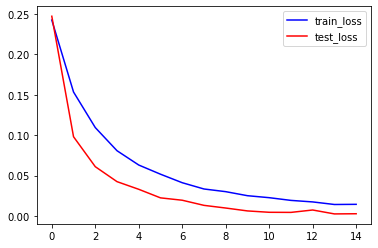

In [237]:
model7 = CNN_D_BN(dropout=0.2)
optimizer7 = optim.RMSprop(model7.parameters(),alpha = 0.9,lr=0.001)
history7 = fit(epochs=15,model=model7,train_loader=train_loader1,test_loader=test_loader,optimizer=optimizer7)
plot_loss(history7)

### Comparing losses of vanilla, with dropout and with batchnorm

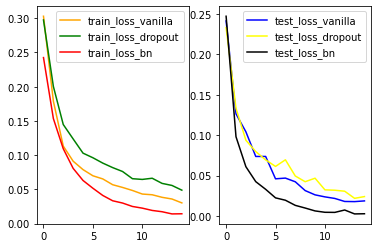

In [238]:
iters = range(15)
train_loss1 = []
train_loss2 = []
train_loss3 = []
test_loss1 = []
test_loss2 = []
test_loss3 = []
fig,(ax1,ax2) = plt.subplots(1,2)
for i in range(15):
    train_loss1.append(history3[i]['train_loss'])
    train_loss2.append(history4[i]['train_loss'])    
    train_loss3.append(history7[i]['train_loss']) 
    test_loss1.append(history3[i]['test_loss'])
    test_loss2.append(history4[i]['test_loss'])
    test_loss3.append(history7[i]['test_loss'])
ax1.plot(iters,train_loss1,'orange',label='train_loss_vanilla')
ax1.plot(iters,train_loss2,'green',label='train_loss_dropout')
ax1.plot(iters,train_loss3,'red',label='train_loss_bn')
ax2.plot(iters,test_loss1,'blue',label='test_loss_vanilla')
ax2.plot(iters,test_loss2,'yellow',label='test_loss_dropout')
ax2.plot(iters,test_loss3,'black',label='test_loss_bn')
ax1.legend()
ax2.legend()
plt.show()

Training loss with batch norm should converge faster than vanilla which is seen here. And training with dropout will generally take longer to converge than vanilla. 